# Rod Pump Failure Analysis

In [512]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [513]:
# read the csv file
df = pd.read_csv('../data/rodpump_failure_final.csv')

# Data Cleaning

In [514]:
# check the shape and columns of the dataframe
print(f'Dataframe shape:\n  {df.shape[1]} columns and {df.shape[0]} rows')
print(f'Columns:\n{df.columns}')

Dataframe shape:
  55 columns and 2596 rows
Columns:
Index(['roduid', 'UWI', 'NODEID', 'IDWELL', 'tbguid', 'lifetime_start',
       'lifetime_end', 'IDRECJOBPULL', 'REPORTTO', 'FAILSTART', 'FAILURETYPE',
       'H2S_CONCENTRATION', 'PrimarySetpoint', 'SecondarySetpoint',
       'StrokeLength', 'GrossStrokeLength', 'Fillage', 'YesterdaysAverageSPM',
       'bha_configuration', 'chemgroup1_any', 'chemgroup1_all',
       'chemgroup2_any', 'chemgroup2_all', 'chemgroup3_any', 'chemgroup3_all',
       'max_unguided_dls', 'dls_high_in_hole', 'gas_anchor_length',
       'MAX_INCLINATION', 'wellbore_category', 'manual_scale', 'packer_vs_tac',
       'AVG_PRESS_FLOWLINE', 'AVG_PRESSURE_TUBING', 'AVG_PRESSURE_CASING',
       'AVG_DIFFERENTIAL_PRESSURE', 'AVG_OIL_VOLUME', 'AVG_WATER_VOLUME',
       'AVG_LIQUID_VOLUME', 'AVG_WATERSG', 'rod_sinker_type', 'rod_has_guides',
       'rod_make', 'rod_apigrade', 'ROUTE', 'overall_max_sideload',
       'shallow_max_sideload', 'max_unguided_sideload', 'DESA

In [515]:
# renaming the columns to make them more intuitive and easier to use
df.rename(columns={'roduid':'rod_uid',
                       'UWI':'uwi',
                       'NODEID':'well_name',
                       'IDWELL':'well_id',
                       'tbguid':'bha_tubing_id',
                       'lifetime_start':'bha_lifetime_start',
                       'lifetime_end' :'bha_lifetime_end',
                       'IDRECJOBPULL' : 'bha_lifetime_id',
                       'REPORTTO' : 'failure_type',
                       'H2S_CONCENTRATION' : 'h2s_conc',
                       'PrimarySetpoint' : 'primary_setpoint',
                       'SecondarySetpoint' : 'secondary_setpoint',
                       'StrokeLength' : 'stroke_len',
                       'GrossStrokeLength' : 'gross_stroke_len',
                       'Fillage' : 'fillage',
                       'YesterdaysAverageSPM' : 'yesterday_avg_spm',
                       'bha_configuration' : 'bha_config',
                       'gas_anchor_length' : 'gas_anchor_len',
                       'MAX_INCLINATION' : 'max_incline',
                       'AVG_PRESS_FLOWLINE' : 'avg_press_flowline',
                       'AVG_PRESSURE_TUBING' : 'avg_press_tubing',
                       'AVG_PRESSURE_CASING' : 'avg_press_casing',
                       'AVG_DIFFERENTIAL_PRESSURE' : 'avg_diff_press',
                       'AVG_OIL_VOLUME' : 'avg_oil_vol',
                       'AVG_WATER_VOLUME' : 'avg_water_vol',
                       'AVG_LIQUID_VOLUME' : 'avg_liquid_vol',
                       'AVG_WATERSG' : 'avg_watersg',
                       'ROUTE' : 'route',
                       'DESANDDEGAS_TYP' : 'dsand_dgas_type',
                       'CHROME_LENGTH' : 'chrome_len',
                       'ENDURALLOY_LENGTH' : 'enduralloy_len',
                       'POLY_LENGTH' : 'poly_len',
                       'NIPPLE_SET_DEPTH' : 'nip_set_depth',
                       'gasanchor_od' : 'gas_anchor_od'}, inplace = True)

# drop unnecessary columns
df.drop(columns = ['FAILSTART', 'FAILURETYPE'], inplace = True)
df['manual_scale'] = df['manual_scale'].map({'Y': True, 'N': False})
for col in df.columns:
    if len(df[col].unique()) == 2:
        df[col] = df[col].astype(bool)

# Get rid of liner casing failure, as per the instructions
df = df[df['failure_type'] != 'Liner (Casing)']

# convert date columns to datetime and create a new column 'bha_lifetime'
date_cols = ['bha_lifetime_start', 'bha_lifetime_end']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])
df['bha_lifetime'] = (df['bha_lifetime_end'] - df['bha_lifetime_start']).dt.days

In [516]:
df.loc[df["bha_lifetime_end"] == "2020-04-15 17:37:11.338", 'failure_type'] = df['failure_type'].fillna("No fail")

In [517]:
# creating new dataframes to separate each type of data
df_numeric = df.select_dtypes(include = 'number')
df_bool = df.select_dtypes(include = 'bool')
df_cat = df.select_dtypes(include = 'object')
df_id = pd.DataFrame()
for col in df_cat.columns:
    if len(df_cat[col].unique()) >= 10:
        df_id[col] = df_cat.pop(col) # leave out identifier columns and add to df_id

df_new = df.copy()

## Handling Null Values

In [518]:
# creating new dataframes to visualize distributions for each type of data
df_new_numeric = df_new.select_dtypes(include = 'number')
df_new_bool = df_new.select_dtypes(include = 'bool')
df_new_cat = df_new.select_dtypes(include = 'object')
df_new_id = pd.DataFrame()
for col in df_new_cat.columns:
    if len(df_new_cat[col].unique()) >= 10:
        df_new_id[col] = df_new_cat.pop(col) # leave out identifier columns and add to df_id

In [519]:
# for numeric columns, fill missing values with the median
# use the median because the data is heavily skewed
for col in df_new_numeric.columns:
    df_new[col] = df_new[col].fillna(df_new[col].median())

# for categorical columns, fill missing values with the mode (or "Unknown" if mode is not available)
for col in df_new_cat.columns:
    df_new[col] = df_new[col].fillna(df_new[col].mode()[0])

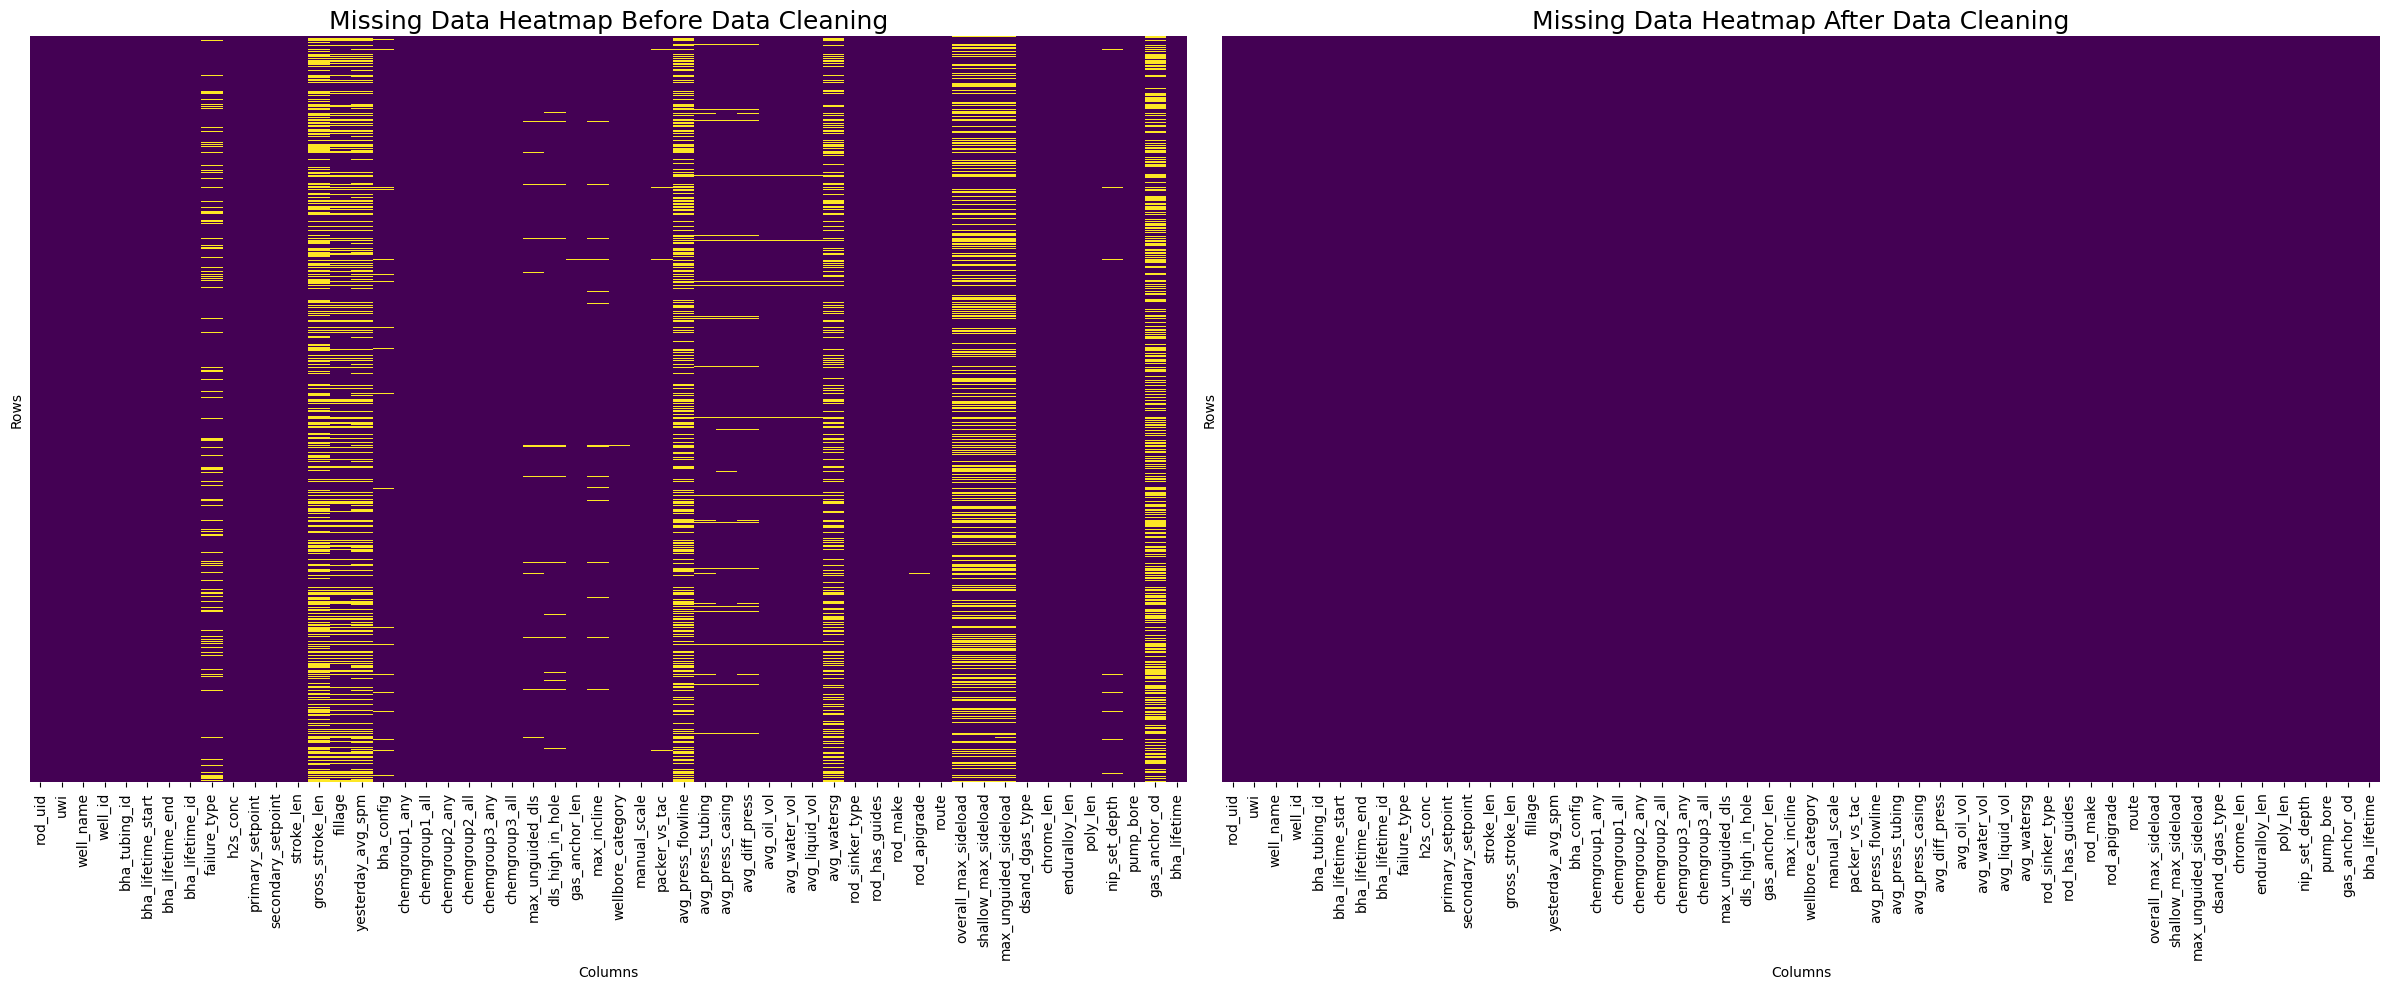

In [520]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # 1 row, 2 columns

# Heatmap before data cleaning
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[0])
axes[0].set_title('Missing Data Heatmap Before Data Cleaning', fontsize=18)
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Rows')

# Heatmap after data cleaning
sns.heatmap(df_new.isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[1])
axes[1].set_title('Missing Data Heatmap After Data Cleaning', fontsize=18)
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('Rows')

plt.tight_layout()
plt.show()

## Log Transformation and Outlier Removal

In [521]:
from scipy.stats import skewtest

def log_transform(data, col):
    """Apply a log1p transformation to the specified column to reduce skewness, ignoring non-positive values."""
    if (data[col] < 0).any():
        print(f"Skipping log transform for {col} due to negative values.")
        return data
    # Only transform if all values are >= 0
    data[col] = np.log1p(data[col])
    data.rename(columns={col: col + '_log'}, inplace=True)
    return data

# For each numeric column, check the skewness and apply log transformation if skewtest p-value < 0.05 and skewness magnitude > 1
for col in df_new_numeric.columns:
    stat, p_value = skewtest(df_new[col])  # Avoid NaNs in test
    if p_value < 0.05 and abs(stat) > 1:
        df_new = log_transform(df_new, col)
df_new_numeric = df_new.select_dtypes(include = 'number')
# Calculate the median and MAD
for col in df_new_numeric.columns:
    median = df_new[col].median()
    mad = np.median(np.abs(df_new[col] - median))
    
    threshold = 3  # You can adjust this
    mask = np.abs(df_new[col] - median) / mad <= threshold  # keep only non-outliers

df_new = df_new[mask]
print()
print(f'Dataframe Shape Before Outlier Removal: {df.shape}')
print(f'Dataframe Shape After Outlier Removal: {df_new.shape}')
print(f'{df.shape[0] - df_new.shape[0]} rows were removed from the dataset.')

Skipping log transform for avg_diff_press due to negative values.

Dataframe Shape Before Outlier Removal: (2592, 54)
Dataframe Shape After Outlier Removal: (2381, 54)
211 rows were removed from the dataset.


# EDA Visuals

In [522]:
# creating new dataframes to visualize distributions for each type of data
df_new_numeric = df_new.select_dtypes(include = 'number')
df_new_bool = df_new.select_dtypes(include = 'bool')
df_new_cat = df_new.select_dtypes(include = 'object')
df_new_id = pd.DataFrame()
for col in df_new_cat.columns:
    if len(df_new_cat[col].unique()) >= 10:
        df_new_id[col] = df_new_cat.pop(col) # leave out identifier columns and add to df_id

In [523]:
print('Identification Columns Before Data Cleaning')
for col in df_id.columns:
    print(f'Number of unique values in {col}: {df_id[col].nunique()}')

print('\nIdentification Columns After Data Cleaning')
for col in df_new_id.columns:
    print(f'Number of unique values in {col}: {df_new_id[col].nunique()}')

Identification Columns Before Data Cleaning
Number of unique values in rod_uid: 2592
Number of unique values in uwi: 633
Number of unique values in well_name: 633
Number of unique values in well_id: 633
Number of unique values in bha_tubing_id: 1815
Number of unique values in bha_lifetime_id: 1689

Identification Columns After Data Cleaning
Number of unique values in rod_uid: 2381
Number of unique values in uwi: 628
Number of unique values in well_name: 628
Number of unique values in well_id: 628
Number of unique values in bha_tubing_id: 1737
Number of unique values in bha_lifetime_id: 1612


## Distribution Visuals

### Numerical Variables

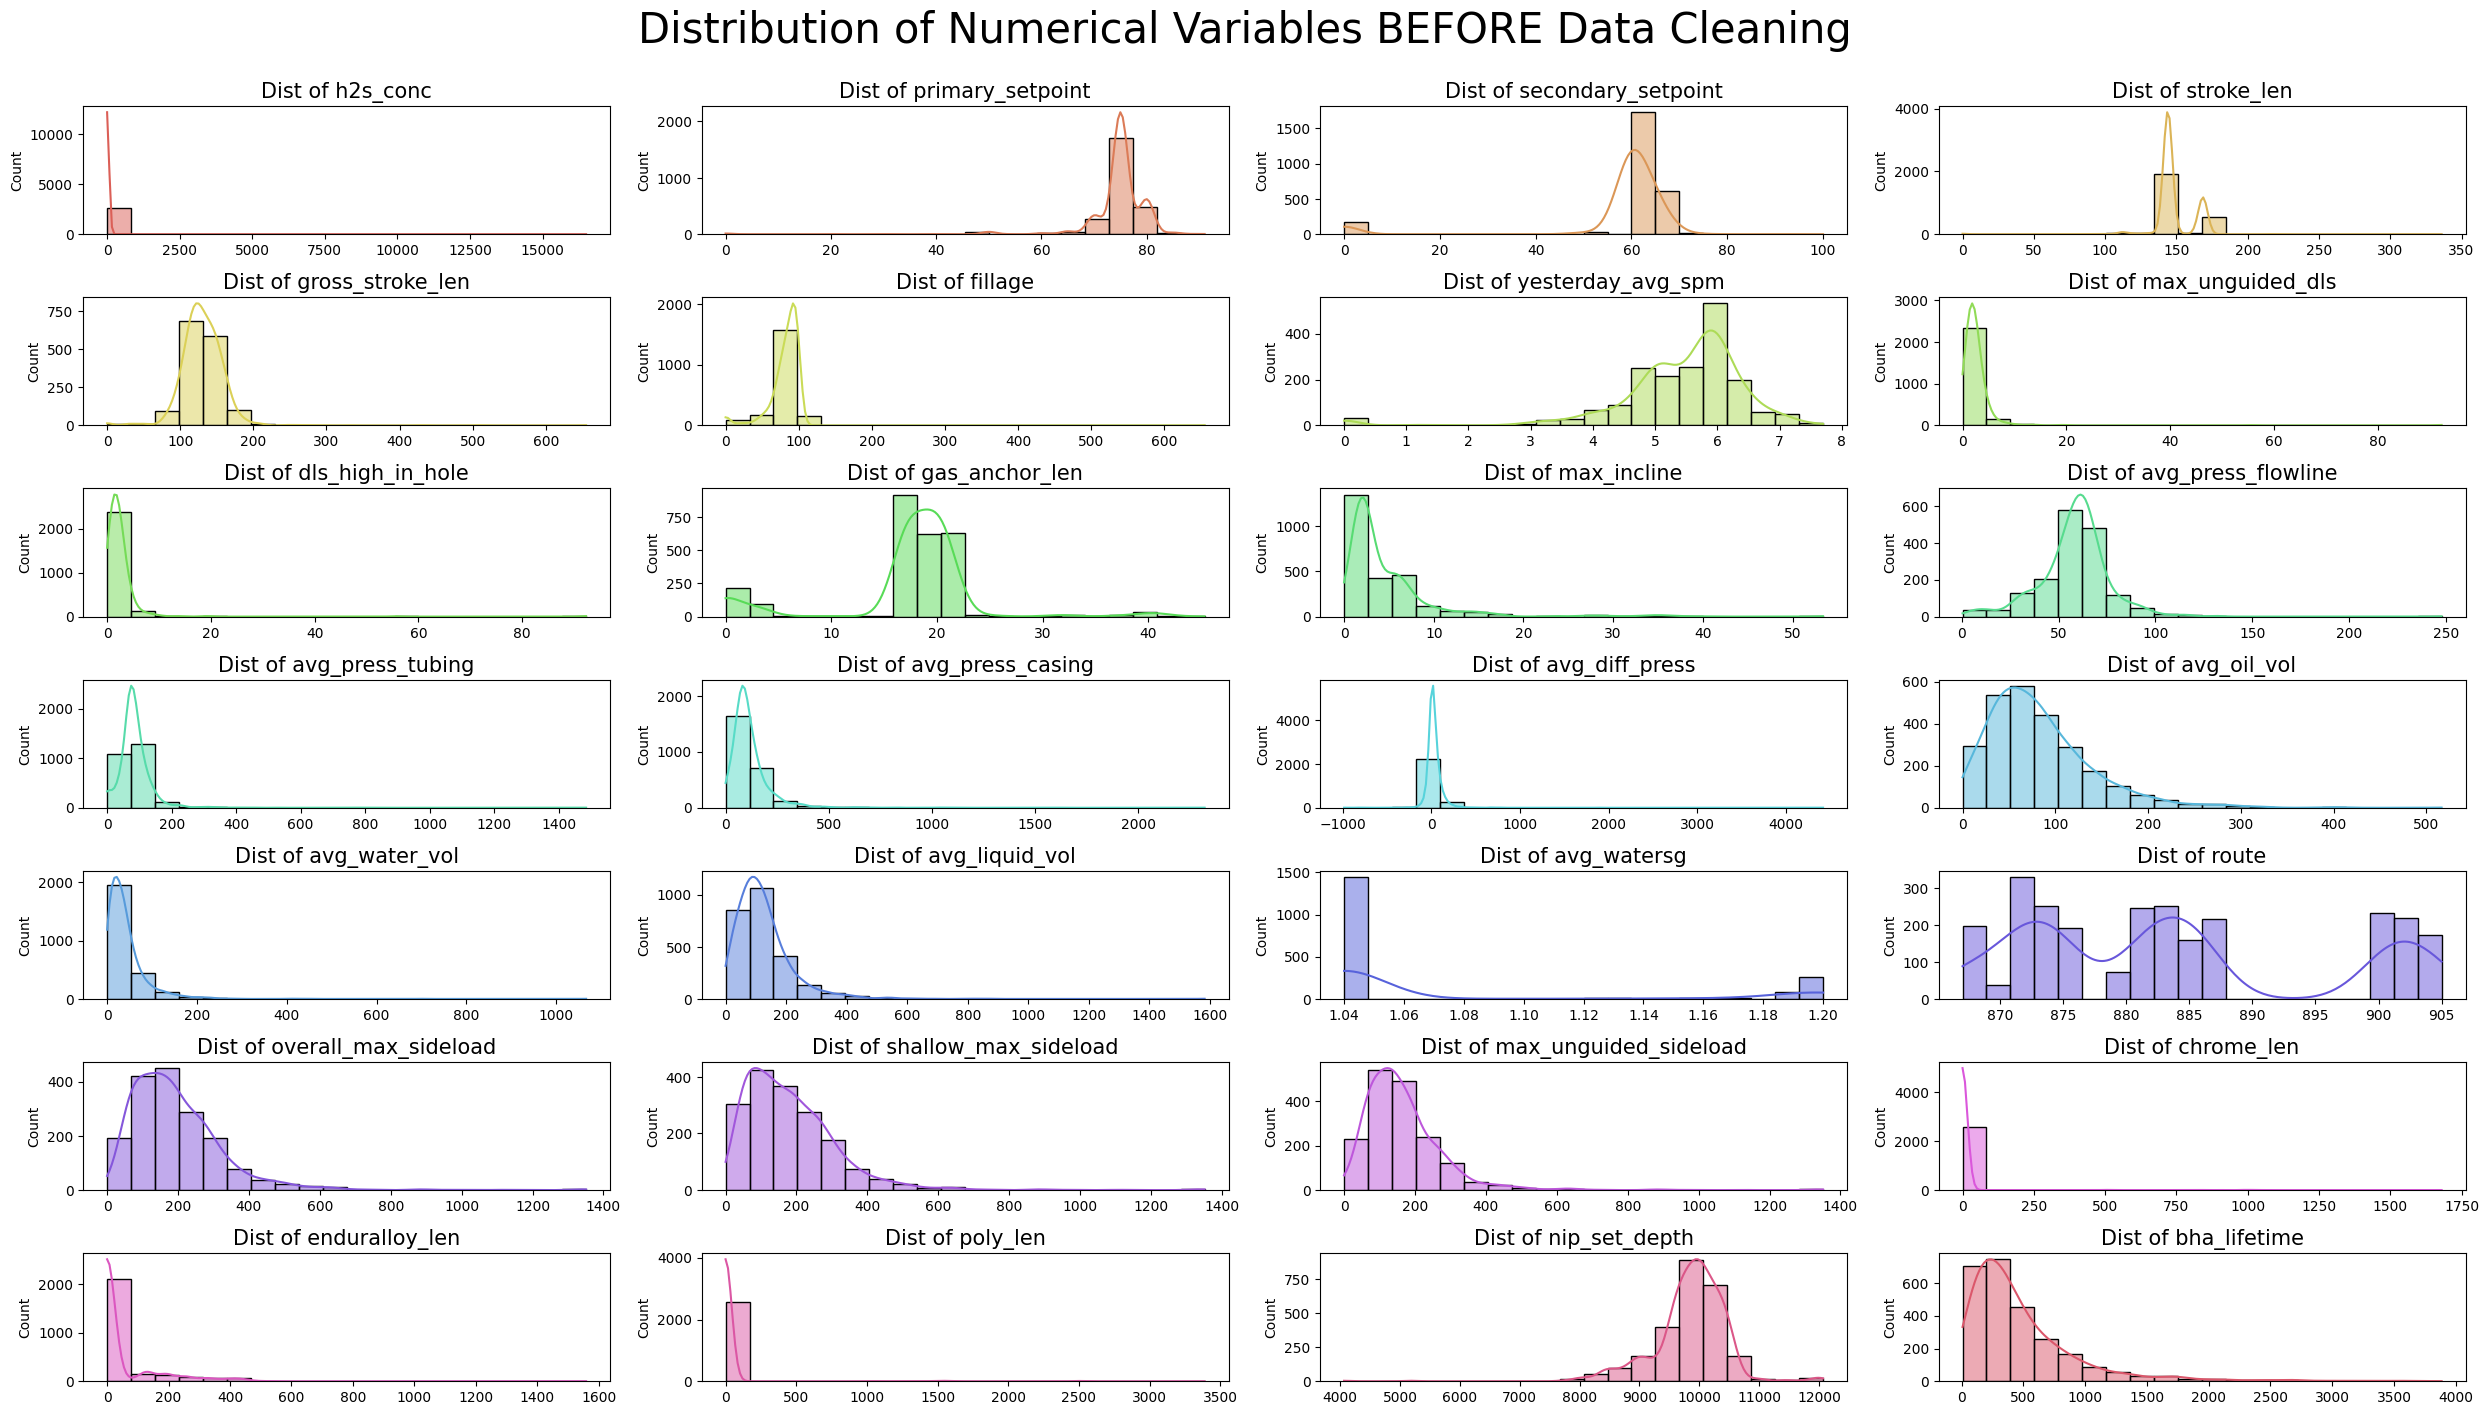

In [524]:
# BEFORE data cleaning
fig, axes = plt.subplots(10, 4, figsize=(25, 20))
axes = axes.flatten()
palette = sns.color_palette("hls", len(df_numeric.columns))

# histograms for each numeric column
for i, col in enumerate(df_numeric.columns):
    sns.histplot(df_numeric[col], kde=True, ax=axes[i], bins=20, color=palette[i])
    axes[i].set_title(f'Dist of {col}', fontsize=15)
    axes[i].tick_params(axis='both', which='both', labelsize=10)
    axes[i].set_xlabel('', fontsize=1)
    axes[i].set_ylabel('Count', fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Numerical Variables BEFORE Data Cleaning', fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

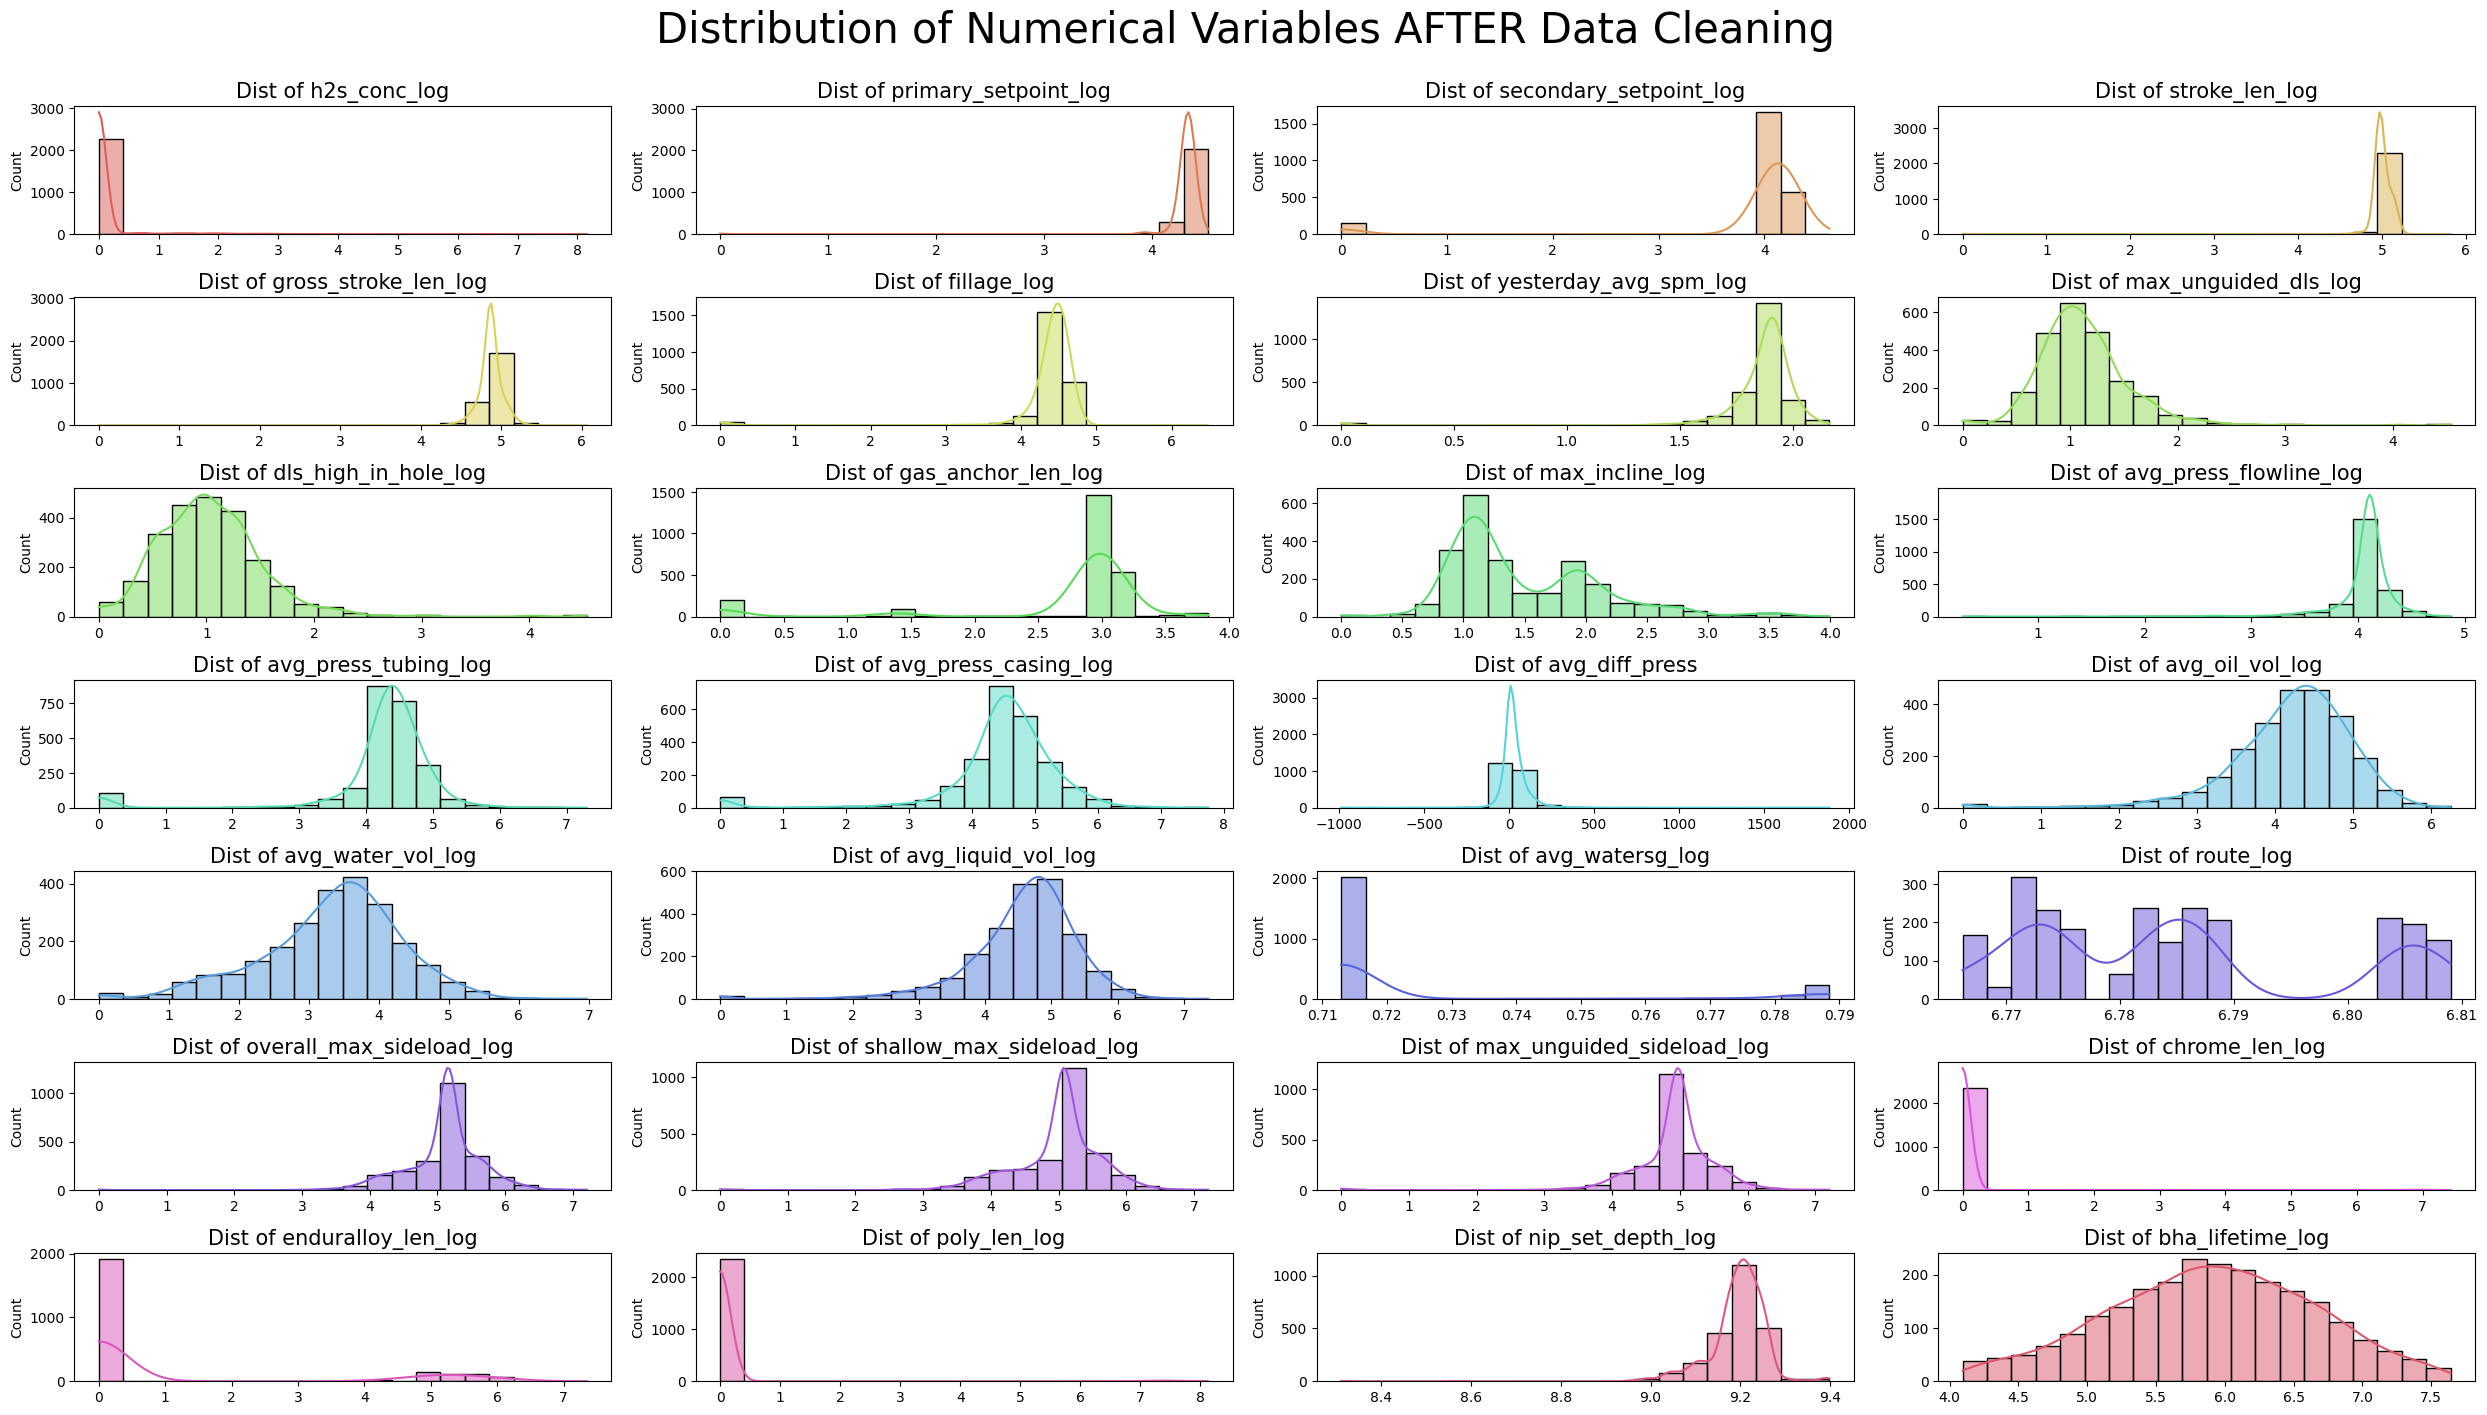

In [525]:
# AFTER data cleaning
fig, axes = plt.subplots(10, 4, figsize=(25, 20))
axes = axes.flatten()
palette = sns.color_palette("hls", len(df_new_numeric.columns))

# histograms for each numeric column
for i, col in enumerate(df_new_numeric.columns):
    sns.histplot(df_new_numeric[col], kde=True, ax=axes[i], bins=20, color=palette[i])
    axes[i].set_title(f'Dist of {col}', fontsize=15)
    axes[i].tick_params(axis='both', which='both', labelsize=10)
    axes[i].set_xlabel('', fontsize=1)
    axes[i].set_ylabel('Count', fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Numerical Variables AFTER Data Cleaning', fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

### Categorical Variables

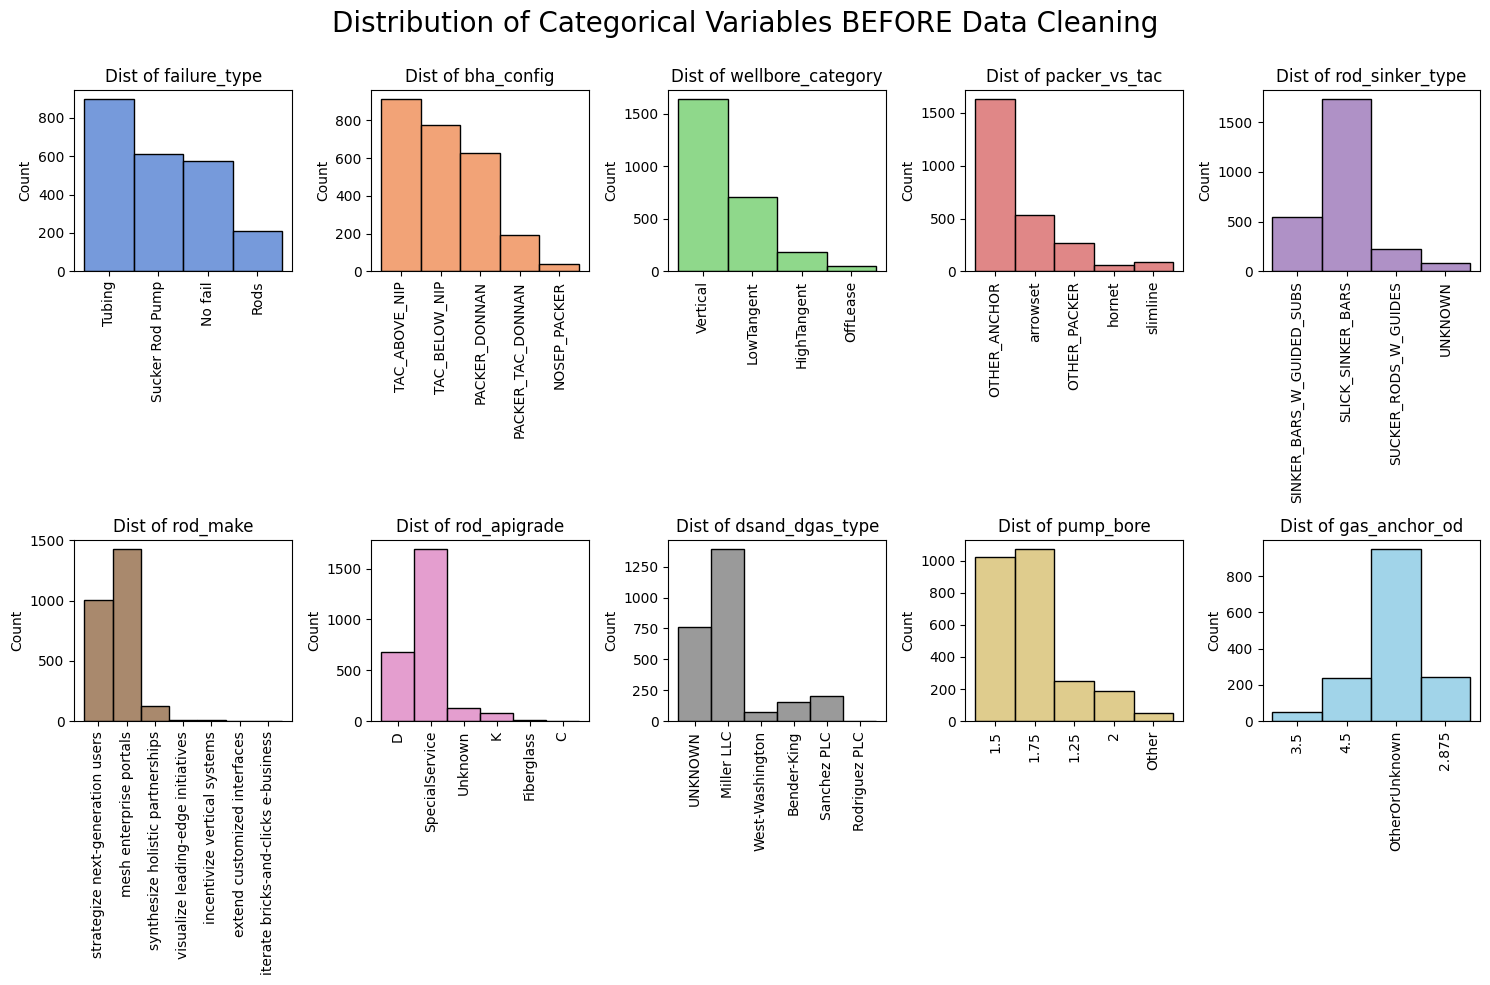

In [526]:
# BEFORE data cleaning
fig, axes = plt.subplots(2, 5, figsize = (15, 10))
axes = axes.flatten()
palette = sns.color_palette("muted", len(df_cat.columns))

for i, col in enumerate(df_cat.columns):
    sns.histplot(df_cat[col], ax=axes[i], bins=20, color=palette[i])
    axes[i].set_title(f'Dist of {col}', fontsize = 12)
    axes[i].tick_params(axis='both', which='both', labelsize=10)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_xlabel('', fontsize = 1)
    axes[i].set_ylabel('Count', fontsize = 10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Categorical Variables BEFORE Data Cleaning', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

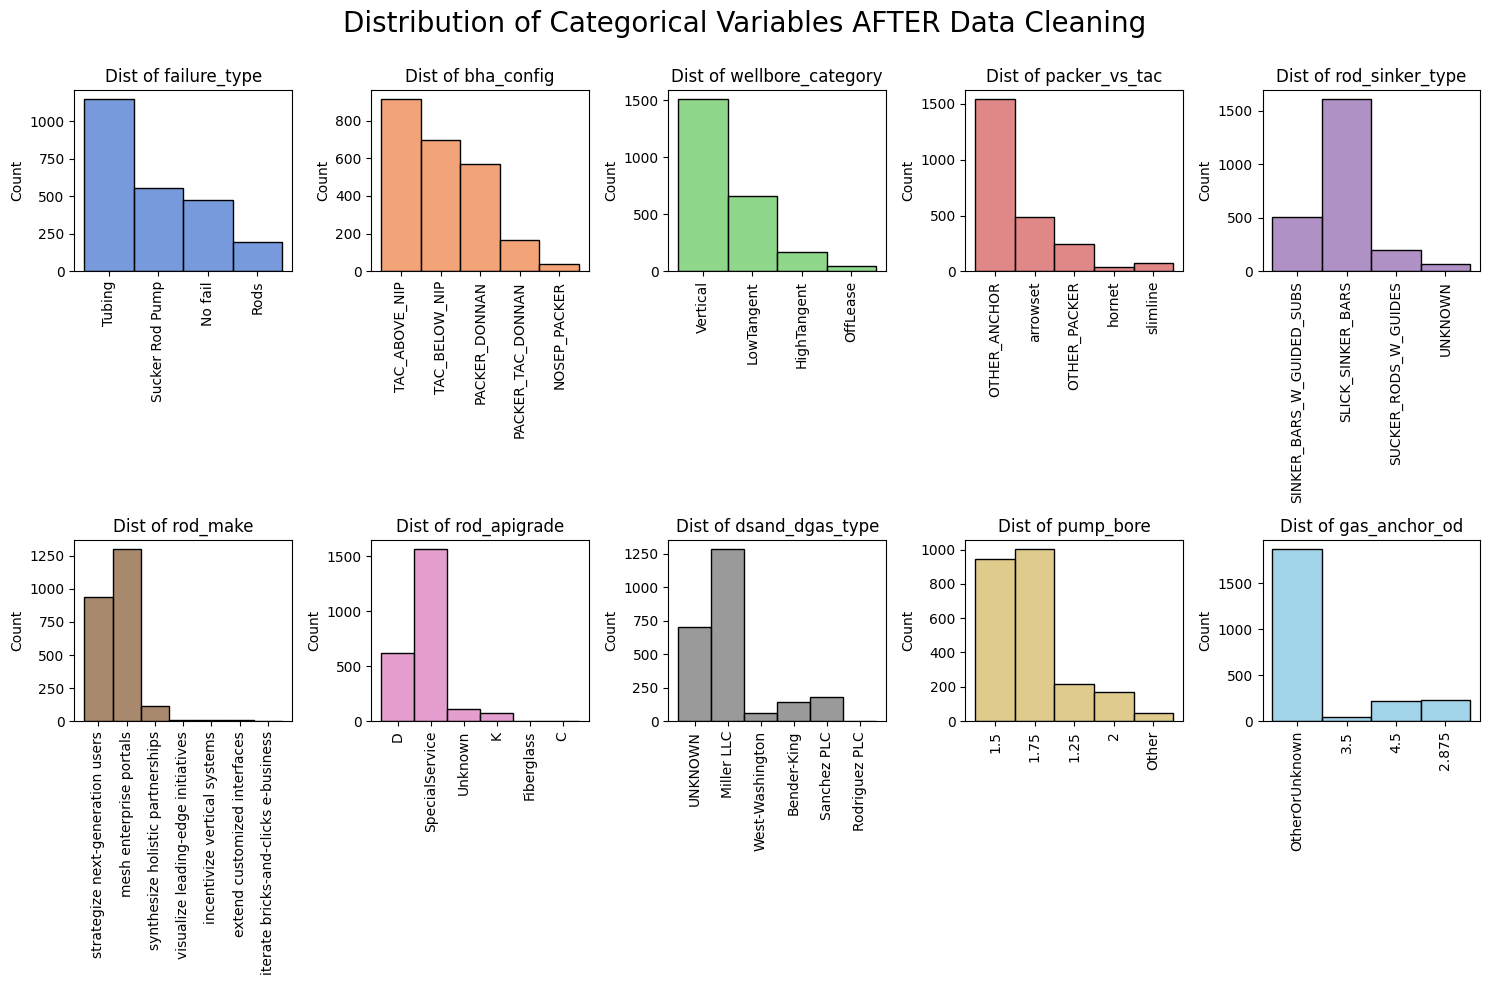

In [527]:
# AFTER data cleaning
fig, axes = plt.subplots(2, 5, figsize = (15, 10))
axes = axes.flatten()
palette = sns.color_palette("muted", len(df_new_cat.columns))

for i, col in enumerate(df_new_cat.columns):
    sns.histplot(df_new_cat[col], ax=axes[i], bins=20, color=palette[i])
    axes[i].set_title(f'Dist of {col}', fontsize = 12)
    axes[i].tick_params(axis='both', which='both', labelsize=10)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_xlabel('', fontsize = 1)
    axes[i].set_ylabel('Count', fontsize = 10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Categorical Variables AFTER Data Cleaning', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

### Boolean Variables

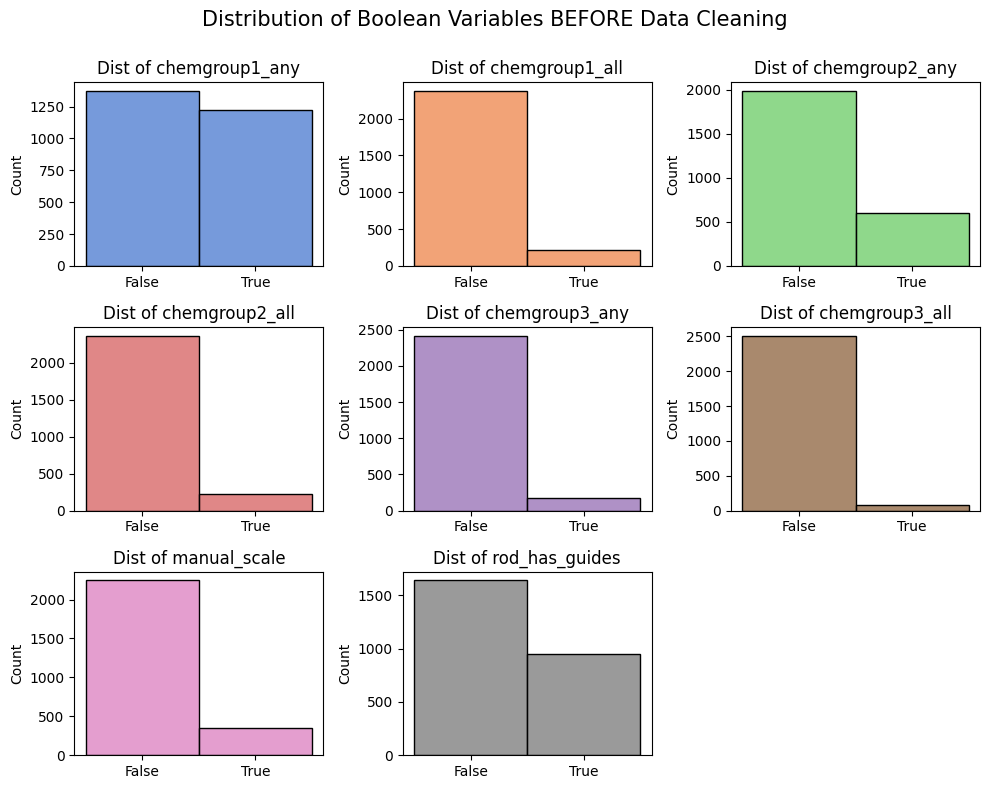

In [528]:
# BEFORE data cleaning
fig, axes = plt.subplots(3, 3, figsize = (10, 8))
axes = axes.flatten()
palette = sns.color_palette("muted", len(df_bool.columns))

for i, col in enumerate(df_bool.columns):
    sns.histplot(df_bool[col], ax=axes[i], color=palette[i], discrete = True)
    axes[i].set_title(f'Dist of {col}', fontsize = 12)
    axes[i].tick_params(axis='both', which='both', labelsize=10)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'])
    axes[i].set_xlabel('', fontsize = 1)
    axes[i].set_ylabel('Count', fontsize = 10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Boolean Variables BEFORE Data Cleaning', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

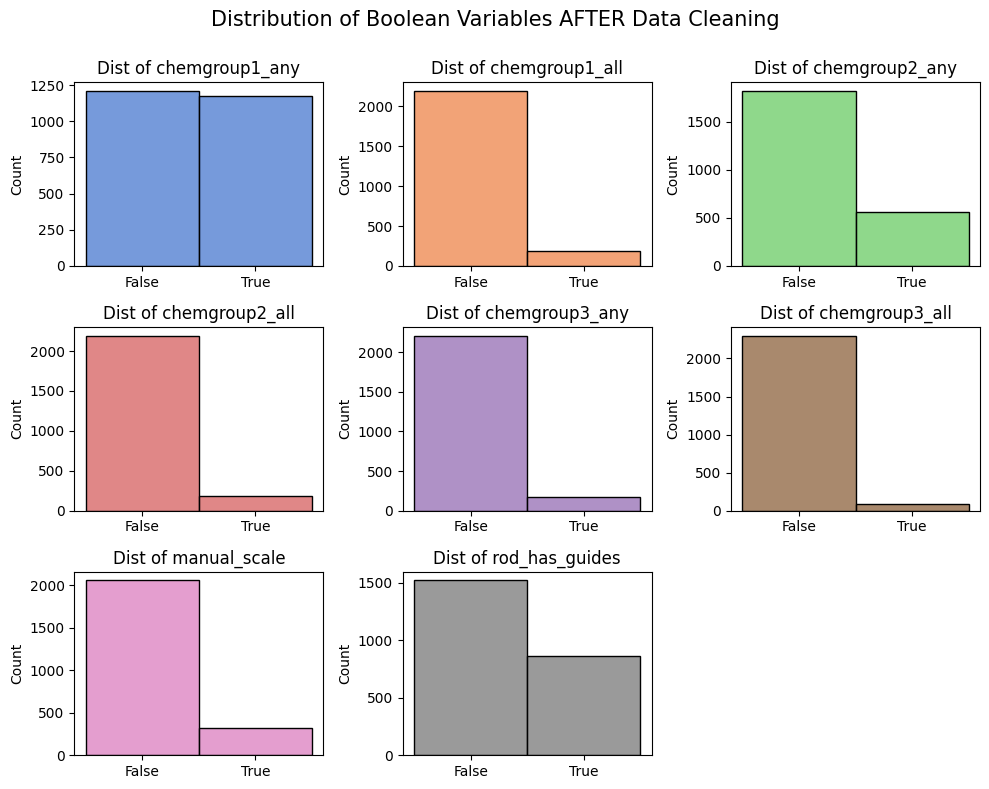

In [529]:
# AFTER data cleaning
fig, axes = plt.subplots(3, 3, figsize = (10, 8))
axes = axes.flatten()
palette = sns.color_palette("muted", len(df_new_bool.columns))

for i, col in enumerate(df_new_bool.columns):
    sns.histplot(df_new_bool[col], ax=axes[i], color=palette[i], discrete = True)
    axes[i].set_title(f'Dist of {col}', fontsize = 12)
    axes[i].tick_params(axis='both', which='both', labelsize=10)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'])
    axes[i].set_xlabel('', fontsize = 1)
    axes[i].set_ylabel('Count', fontsize = 10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Boolean Variables AFTER Data Cleaning', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

In [530]:
# Save the Final Cleaned Data
df_new.to_csv('../data/rod_cleaned_final.csv', index=False)

In [531]:
df = pd.read_csv('../data/rod_cleaned_final.csv')

## Variable Relationships

In [532]:
# creating new dataframes to separate each type of data
df_numeric = df.select_dtypes(include = 'number')
df_bool = df.select_dtypes(include = 'bool')
df_cat = df.select_dtypes(include = 'object')
df_id = pd.DataFrame()
for col in df_cat.columns:
    if len(df_cat[col].unique()) >= 10:
        df_id[col] = df_cat.pop(col) # leave out identifier columns and add to df_id

### Correlation Heatmap

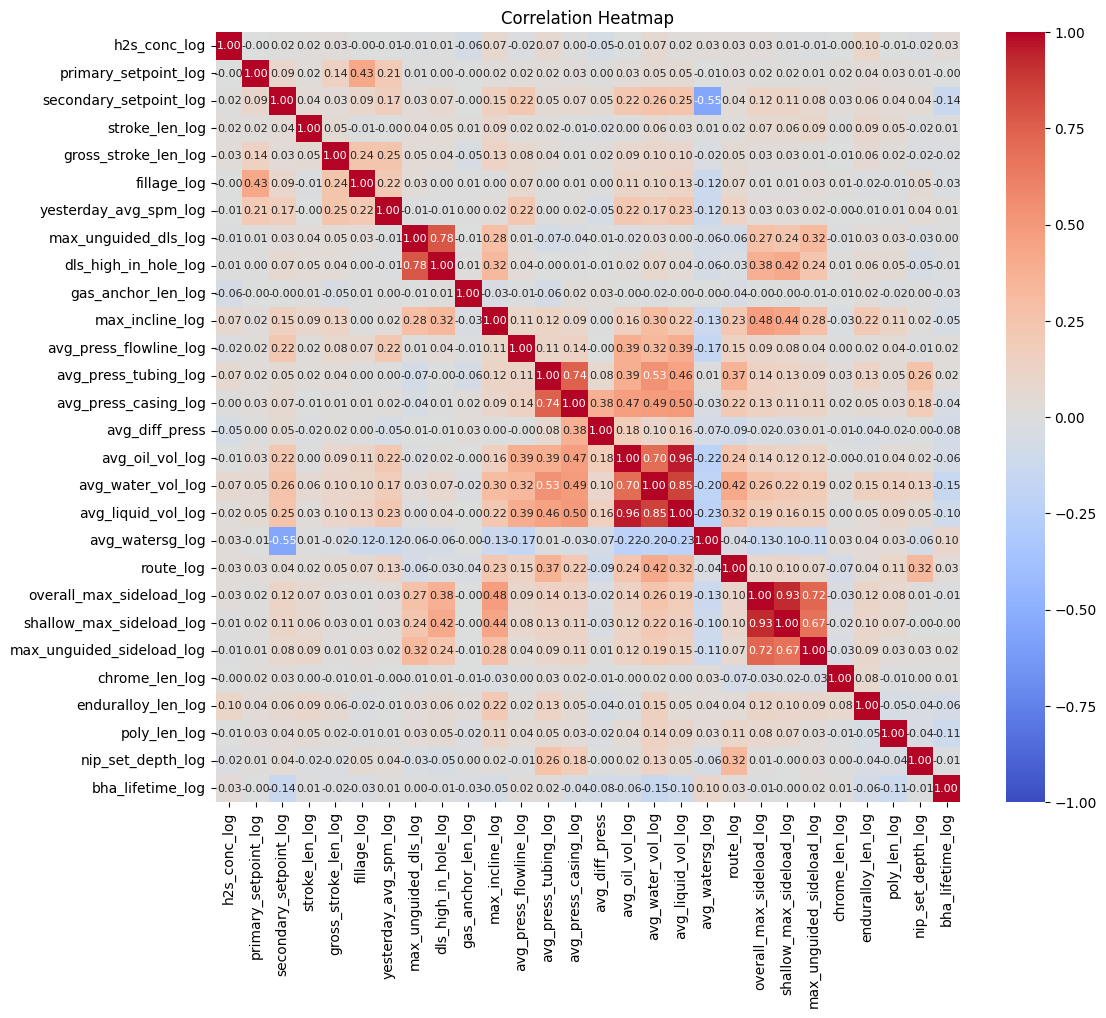

In [533]:
# correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8}, vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

In [534]:
# remove the duplicate correlations
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_values = correlation_matrix.where(~mask).stack()

# extract top correlations
sorted_correlations = correlation_values.sort_values(ascending=False)
top_positive_correlations = sorted_correlations[sorted_correlations > 0].head(5)
top_negative_correlations = sorted_correlations[sorted_correlations < 0].sort_values(ascending=True).head(5)

print("Top 5 Positive Correlations:")
for index, value in top_positive_correlations.items():
    print(f'{index[0]} | {index[1]}: {value:.2f}')

print("\nTop 5 Negative Correlations:")
for index, value in top_negative_correlations.items():
    print(f'{index[0]} | {index[1]}: {value:.2f}')

Top 5 Positive Correlations:
avg_liquid_vol_log | avg_oil_vol_log: 0.96
shallow_max_sideload_log | overall_max_sideload_log: 0.93
avg_liquid_vol_log | avg_water_vol_log: 0.85
dls_high_in_hole_log | max_unguided_dls_log: 0.78
avg_press_casing_log | avg_press_tubing_log: 0.74

Top 5 Negative Correlations:
avg_watersg_log | secondary_setpoint_log: -0.55
avg_watersg_log | avg_liquid_vol_log: -0.23
avg_watersg_log | avg_oil_vol_log: -0.22
avg_watersg_log | avg_water_vol_log: -0.20
avg_watersg_log | avg_press_flowline_log: -0.17


### Pairplot

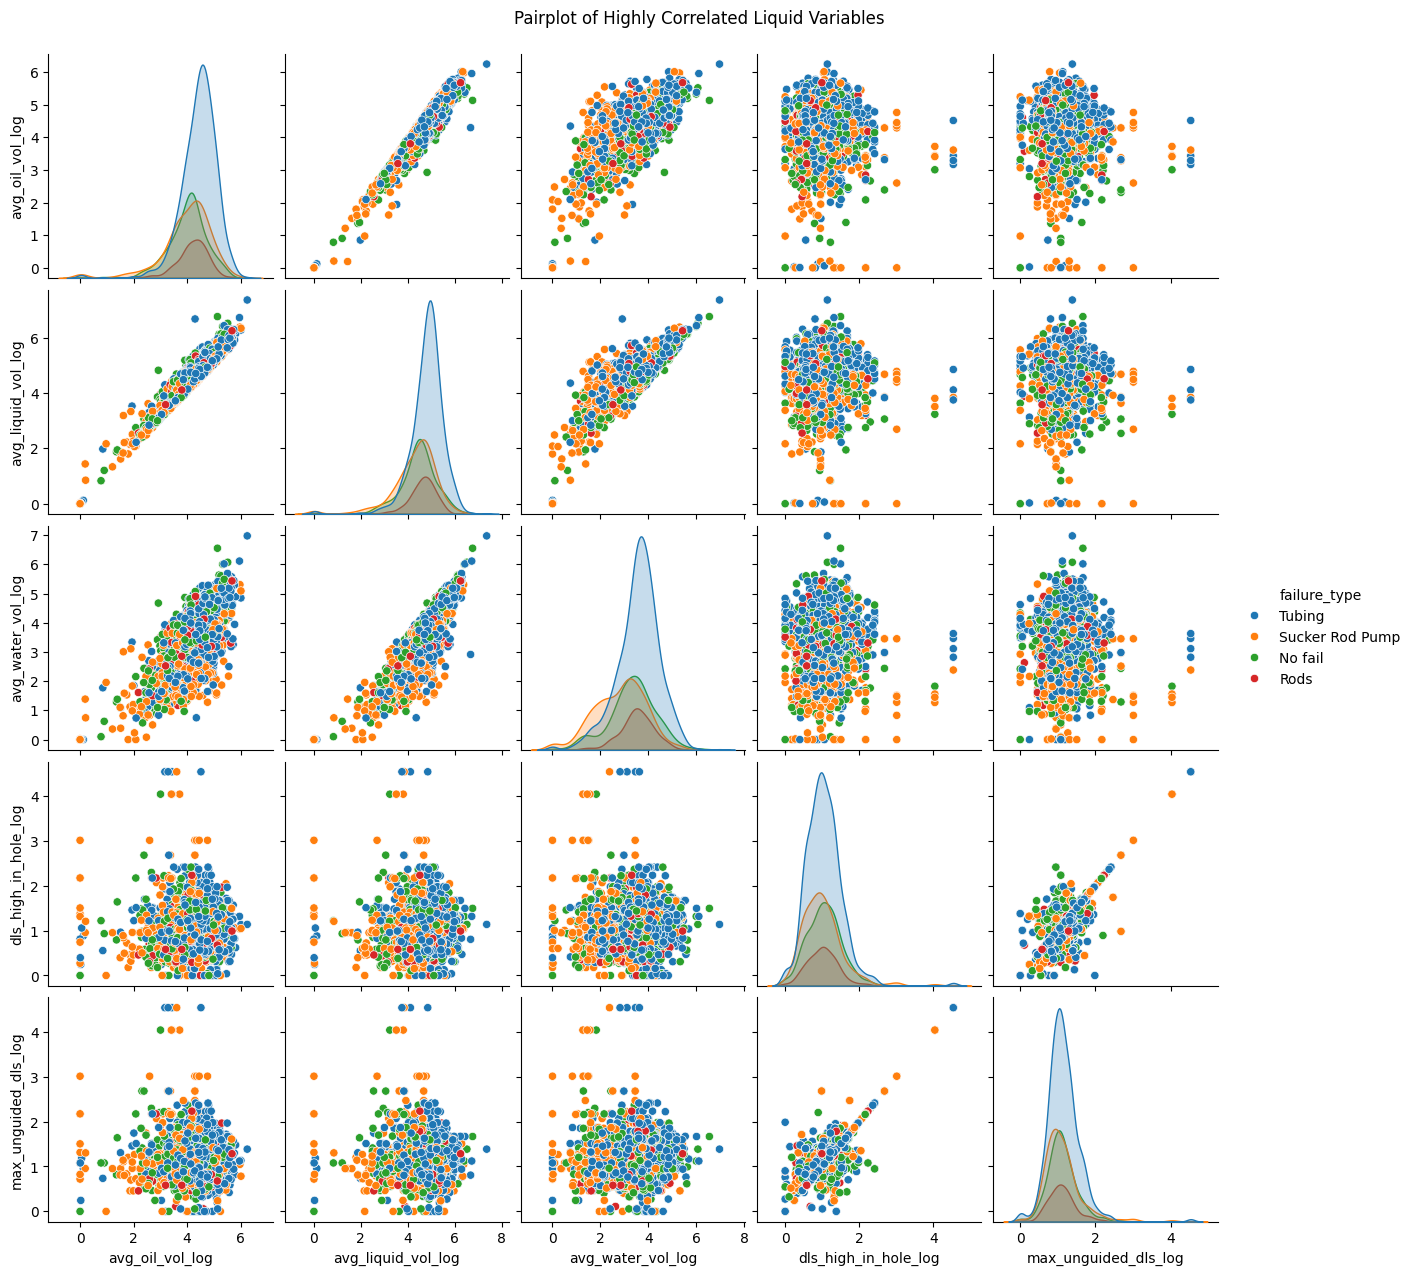

In [535]:
# pairplot of variables highly correlated with average liquid volume
sns.pairplot(df, vars = ['avg_oil_vol_log', 'avg_liquid_vol_log',
                         'avg_water_vol_log', 'dls_high_in_hole_log',
                         'max_unguided_dls_log'], hue = 'failure_type')
plt.suptitle("Pairplot of Highly Correlated Liquid Variables", y=1.02)
plt.show()

### Lifetime vs Numerical Variables

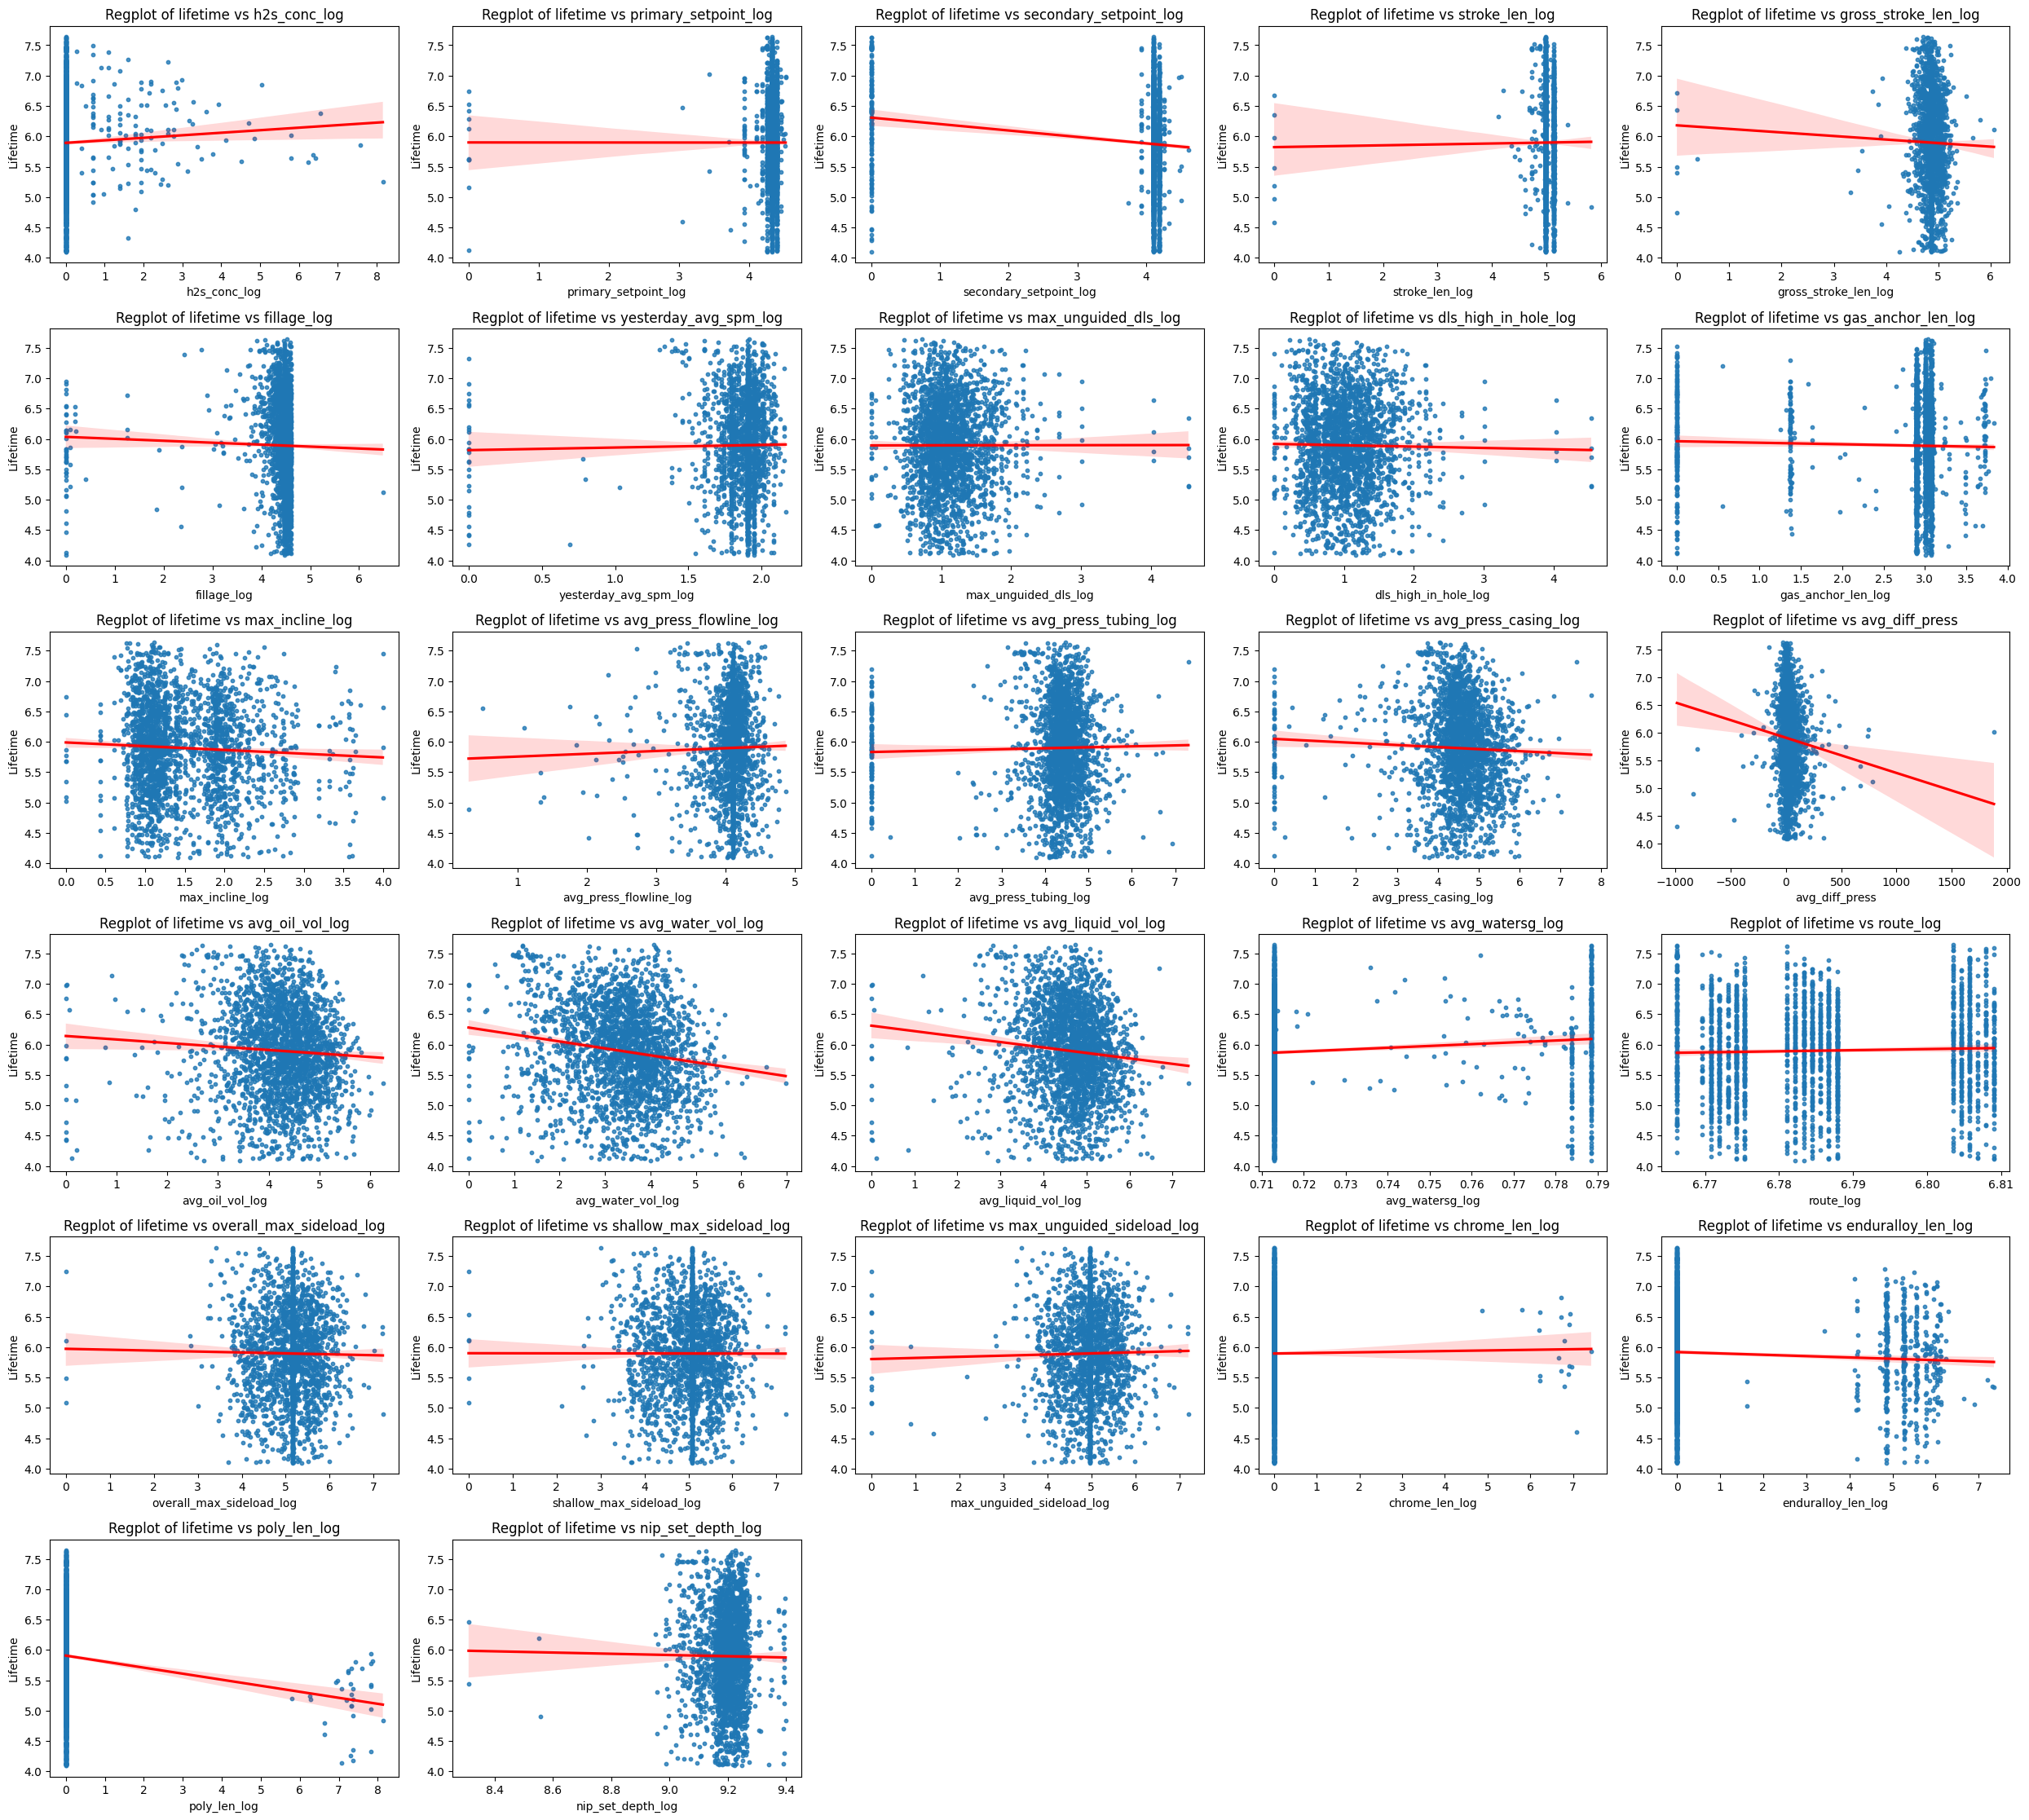

In [536]:
df_num = df_numeric.copy()
df_num.drop(columns = ['bha_lifetime_log'], inplace = True)
fig, axes = plt.subplots(len(df_num.columns), 5, figsize=(25, 100))  # Adjust the height as needed
axes = axes.flatten()

# Iterate through the continuous columns and create regression plots
for i, col in enumerate(df_num.columns):
    sns.regplot(x=col, y='bha_lifetime_log', data=df, ax=axes[i], scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Regplot of lifetime vs {col}', fontsize=12)
    axes[i].tick_params(axis='both', which='both', labelsize=10)
    axes[i].tick_params(axis='x')  # Rotate x-axis labels if needed
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Lifetime', fontsize=10)

# Remove any unused axes if the number of columns is less than the number of subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()

### Lifetime vs Categorical Variables

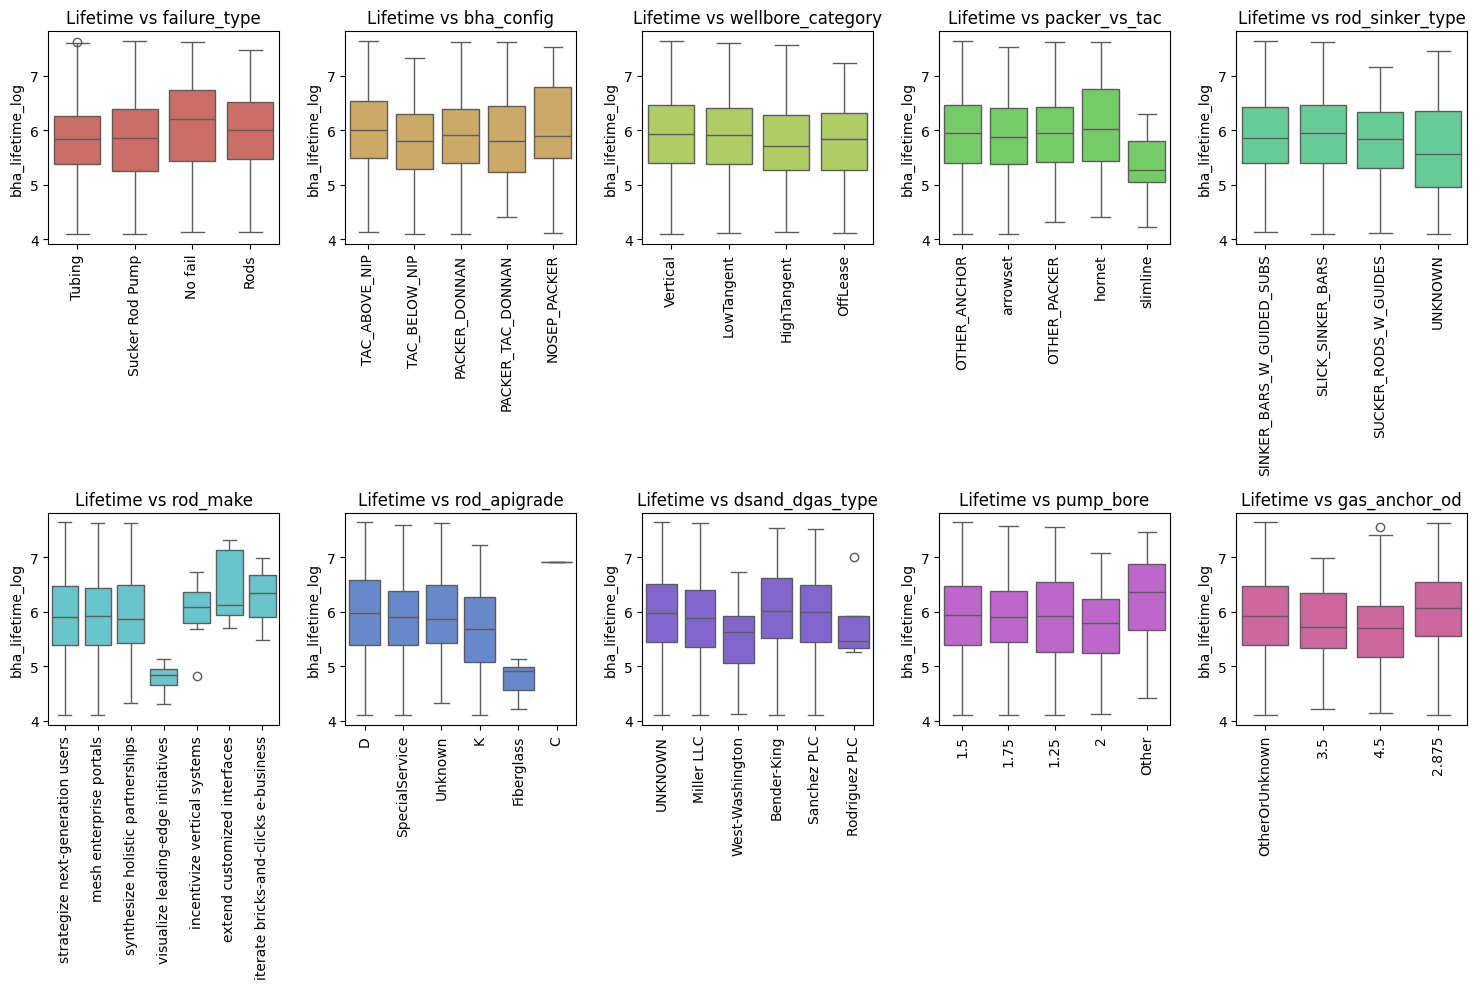

In [537]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
axes = axes.flatten()

palette = sns.color_palette("hls", len(df_cat.columns))

for i, col in enumerate(df_cat.columns):
    sns.boxplot(data=df, x=col, y='bha_lifetime_log', ax=axes[i], color=palette[i])
    axes[i].set_title(f'Lifetime vs {col}', fontsize=12)
    axes[i].tick_params(axis='both', which='both', labelsize=10)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_xlabel('', fontsize = 1)
    axes[i].set_ylabel('bha_lifetime_log', fontsize=10)

# Remove any unused axes if the number of columns is less than the number of subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Lifetime vs Boolean Variables

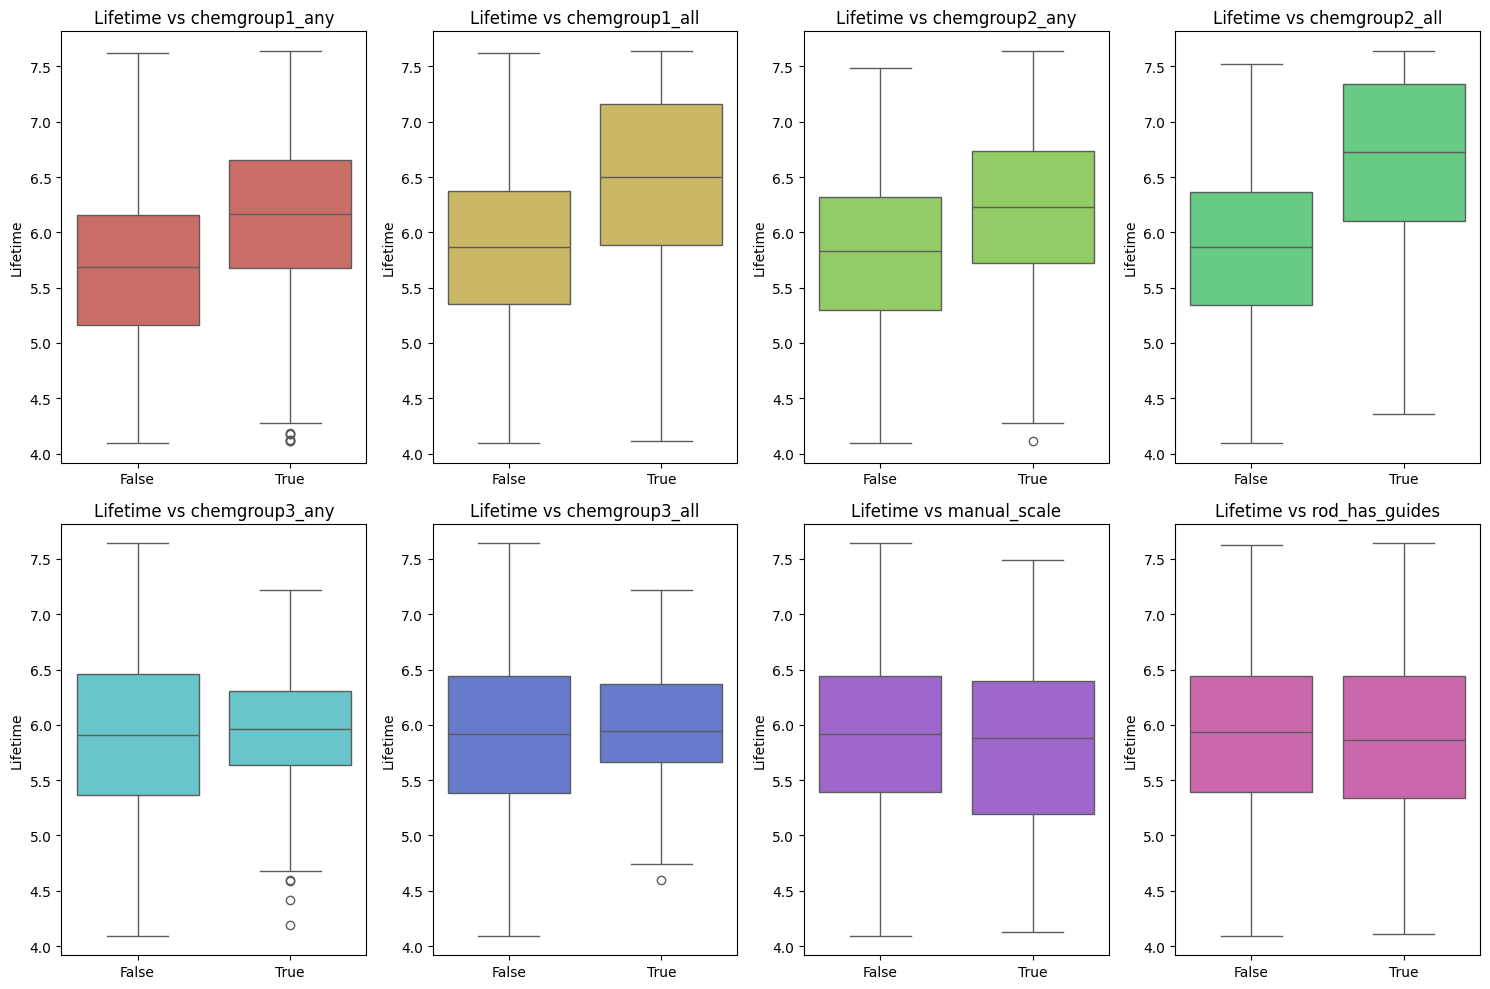

In [538]:
df_bool = df.select_dtypes(include = 'bool')

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()

palette = sns.color_palette("hls", len(df_bool.columns))

for i, col in enumerate(df_bool.columns):
    sns.boxplot(data=df, x=col, y='bha_lifetime_log', ax=axes[i], color=palette[i])
    axes[i].set_title(f'Lifetime vs {col}', fontsize=12)
    axes[i].tick_params(axis='both', which='both', labelsize=10)
    axes[i].tick_params(axis='x')
    axes[i].set_xlabel('', fontsize = 1)
    axes[i].set_ylabel('Lifetime', fontsize=10)

# Remove any unused axes if the number of columns is less than the number of subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# ML Algorithms

In [539]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [540]:
def rf_reg(X_train, X_test, y_train, y_test, n_iter=20, cv=5, random_state=42):
    """
    Random forest regression function, returns the best model and its metrics
    """
    # Define hyperparameter search space
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [10, 30],
        'min_samples_leaf': [10, 20],
        'bootstrap': [True]
    }

    # Initialize model and perform randomized search
    rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)
    random_search = RandomizedSearchCV(
        rf, param_distributions=param_dist, n_iter=n_iter, cv=cv,
        verbose=1, n_jobs=-1, scoring='r2', random_state=random_state
    )
    random_search.fit(X_train, y_train)

    # Train best model
    best_rf = random_search.best_estimator_
    best_rf.fit(X_train, y_train)

    # Predictions
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    # Performance metrics
    metrics = {
        "Train MSE": mean_squared_error(y_train, y_train_pred),
        "Test MSE": mean_squared_error(y_test, y_test_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train R²": r2_score(y_train, y_train_pred),
        "Test R²": r2_score(y_test, y_test_pred)
    }

    # Print results
    print("Performance Comparison: Train vs Test")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return best_rf, metrics

def xgb_reg(X_train, X_test, y_train, y_test, n_iter=20, cv=5, random_state=42):
    """
    XGBoost regression function, returns the best model and its metrics
    """
    # Define hyperparameter space
    param_dist = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }

    xgb = XGBRegressor(objective='reg:squarederror', random_state=random_state, n_jobs=-1)
    random_search = RandomizedSearchCV(
        xgb, param_distributions=param_dist, n_iter=n_iter, cv=cv,
        verbose=1, n_jobs=-1, scoring='r2', random_state=random_state
    )
    random_search.fit(X_train, y_train)

    # Best model
    best_xgb = random_search.best_estimator_
    best_xgb.fit(X_train, y_train)

    # Predictions
    y_train_pred = best_xgb.predict(X_train)
    y_test_pred = best_xgb.predict(X_test)

    # Evaluation
    metrics = {
        "Train MSE": mean_squared_error(y_train, y_train_pred),
        "Test MSE": mean_squared_error(y_test, y_test_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train R²": r2_score(y_train, y_train_pred),
        "Test R²": r2_score(y_test, y_test_pred)
    }

    print("Performance Comparison: Train vs Test")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return best_xgb, metrics

In [541]:
def feat_importance(model, feature_names, top_n=10, color='skyblue', title='Feature Importance'):
    """
    Plots the top N feature importances from a model
    returns importance_df: DataFrame of all features sorted by importance
    """
    # Get importance and sort
    importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Select top N
    top_features = importance_df.head(top_n)

    # Plot
    plt.figure(figsize=(11, 6))
    bars = plt.barh(top_features['Feature'], top_features['Importance'], color=color)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(title)
    plt.gca().invert_yaxis()

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.0001, bar.get_y() + bar.get_height()/2,
                 f'{width:.3f}', va='center')

    plt.tight_layout()
    plt.show()

    return importance_df

## Feature Engineering

In [542]:
df_eng = df.copy()

df_eng["press_efficiency"] = df["avg_press_flowline_log"] - df["avg_press_tubing_log"]
df_eng['stroke_power'] = np.expm1(df['stroke_len_log']) * np.expm1(df['yesterday_avg_spm_log'])
df_eng['oil_ratio'] = df['avg_oil_vol_log'] / (df['avg_liquid_vol_log'] + 1e-6)
df_eng['water_ratio'] = df['avg_water_vol_log'] / (df['avg_liquid_vol_log'] + 1e-6)

# square some key numeric variables to model non-linear relationships.
df_eng['stroke_len_sq'] = df['stroke_len_log'] ** 2

df_eng.drop(columns = ['avg_oil_vol_log', 'avg_liquid_vol_log', 'avg_water_vol_log',
                           'stroke_len_log', 'avg_diff_press', 'h2s_conc_log', 'yesterday_avg_spm_log',
                           'avg_press_flowline_log', 'avg_press_tubing_log',
                           'rod_uid', 'uwi', 'well_name',
                           'well_id', 'bha_tubing_id', 'bha_lifetime_start',
                           'bha_lifetime_end', 'bha_lifetime_id'], inplace = True)

# Create an event column (1 if failure occurred, 0 if no failure)
df_eng["failed"] = df_eng["failure_type"].apply(lambda x: False if x == "No fail" else True)

categorical_cols = df_eng.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_eng[col] = le.fit_transform(df_eng[col].astype(str))
    label_encoders[col] = le

## Regression

In [543]:
df_reg = df_eng[df_eng['failed'] == True].drop(columns = ['failed'])
# define features and target
X = df_reg.drop(columns=['bha_lifetime_log'])
y = df_reg['bha_lifetime_log']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

In [544]:
best_rf, results = rf_reg(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Performance Comparison: Train vs Test
Train MSE: 0.2378
Test MSE: 0.3282
Train MAE: 0.3835
Test MAE: 0.4498
Train R²: 0.5336
Test R²: 0.2570


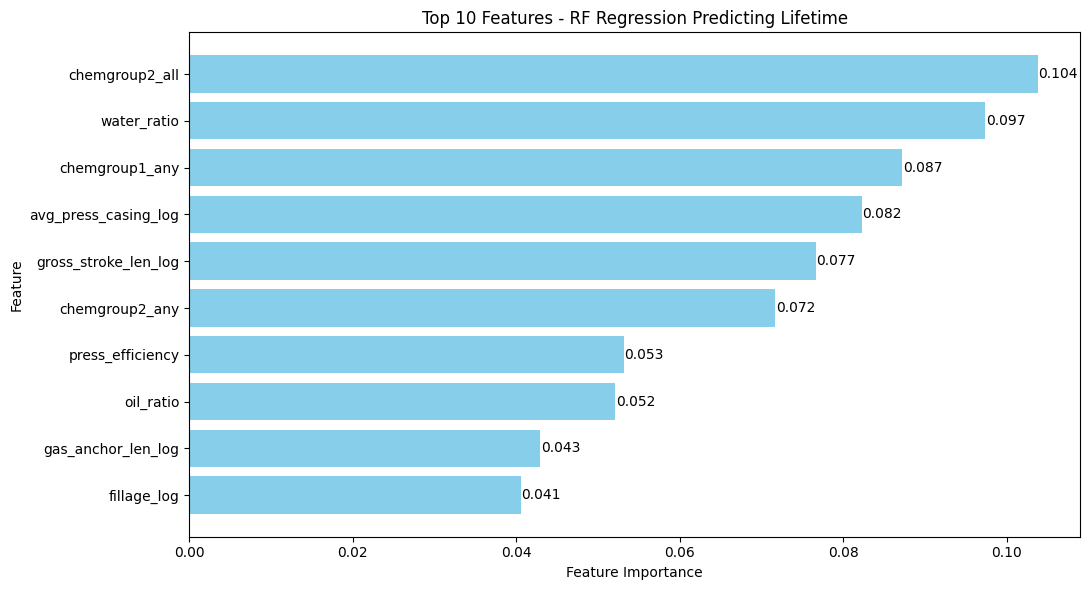

In [545]:
importance_df = feat_importance(best_rf, X_train.columns, top_n=10, title='Top 10 Features - RF Regression Predicting Lifetime')

### XGBoost

In [546]:
best_xgb, results = xgb_reg(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Performance Comparison: Train vs Test
Train MSE: 0.1331
Test MSE: 0.3159
Train MAE: 0.2855
Test MAE: 0.4392
Train R²: 0.7390
Test R²: 0.2848


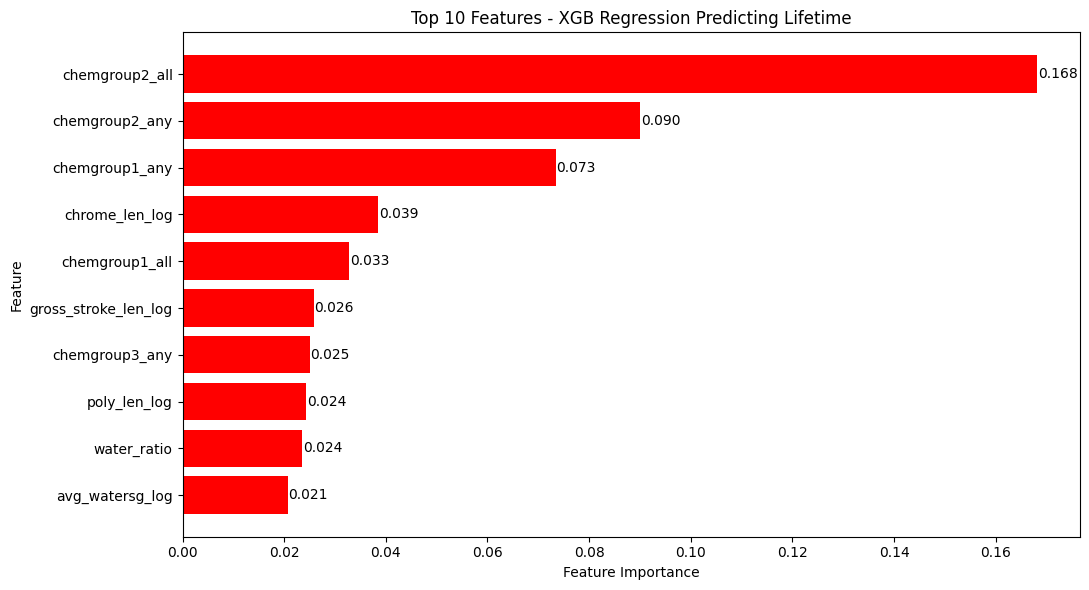

In [547]:
importance_df = feat_importance(best_xgb, X_train.columns, top_n=10, color = 'red', title='Top 10 Features - XGB Regression Predicting Lifetime')

## Classification

### Fail/No Fail

In [548]:
X = df_eng.drop(columns=['failed', 'failure_type'])
y = df_eng['failed']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [549]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
random_search.fit(X_train, y_train)

# Train best model
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Predictions
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Performance evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Performance Comparison: Train vs Test")
print(f"Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f} | Test Precision: {test_precision:.4f}")
print(f"Train Recall: {train_recall:.4f} | Test Recall: {test_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f} | Test F1 Score: {test_f1:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Performance Comparison: Train vs Test
Train Accuracy: 0.9848 | Test Accuracy: 0.8700
Train Precision: 0.9864 | Test Precision: 0.8869
Train Recall: 0.9948 | Test Recall: 0.9541
Train F1 Score: 0.9906 | Test F1 Score: 0.9193


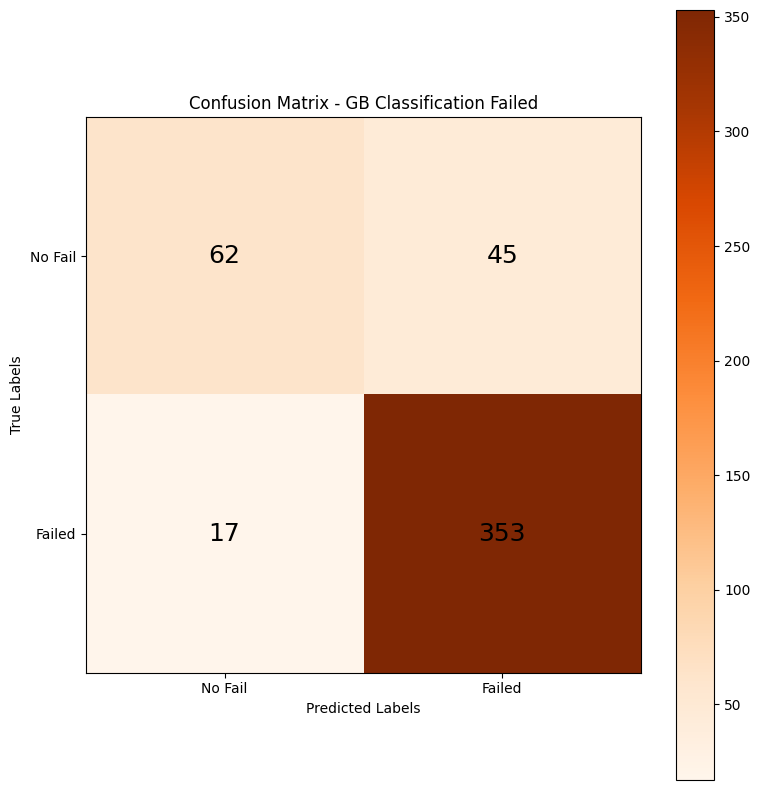

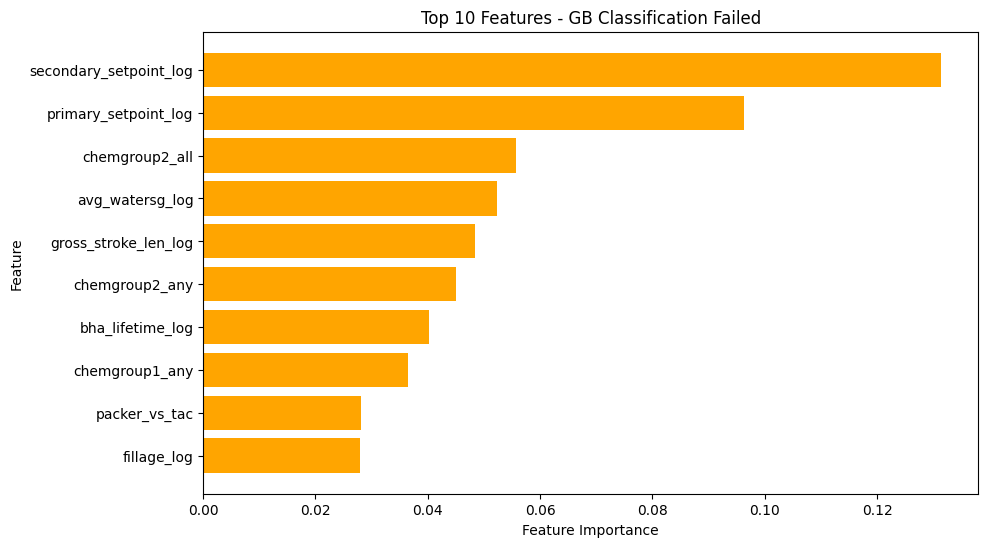

In [550]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, cmap='Oranges', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=["No Fail", "Failed"])
plt.yticks(ticks=[0, 1], labels=["No Fail", "Failed"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - GB Classification Failed")

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]),
                 ha='center', va='center', fontsize=18, color='black')

plt.tight_layout()
plt.show()


# Feature importance
feature_importances = best_xgb.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color = 'orange')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features - GB Classification Failed")
plt.gca().invert_yaxis()
plt.show()

### Failure Type

In [551]:
X = df_eng.drop(columns=['failure_type', 'failed'])
y = df_eng['failure_type']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [552]:
xgb = XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), random_state=42)
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
random_search.fit(X_train, y_train)

# Train best model
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Predictions
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Performance evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Performance Comparison: Train vs Test")
print(f"Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f} | Test Precision: {test_precision:.4f}")
print(f"Train Recall: {train_recall:.4f} | Test Recall: {test_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f} | Test F1 Score: {test_f1:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Performance Comparison: Train vs Test
Train Accuracy: 0.8025 | Test Accuracy: 0.6394
Train Precision: 0.8104 | Test Precision: 0.6201
Train Recall: 0.8025 | Test Recall: 0.6394
Train F1 Score: 0.7893 | Test F1 Score: 0.6096


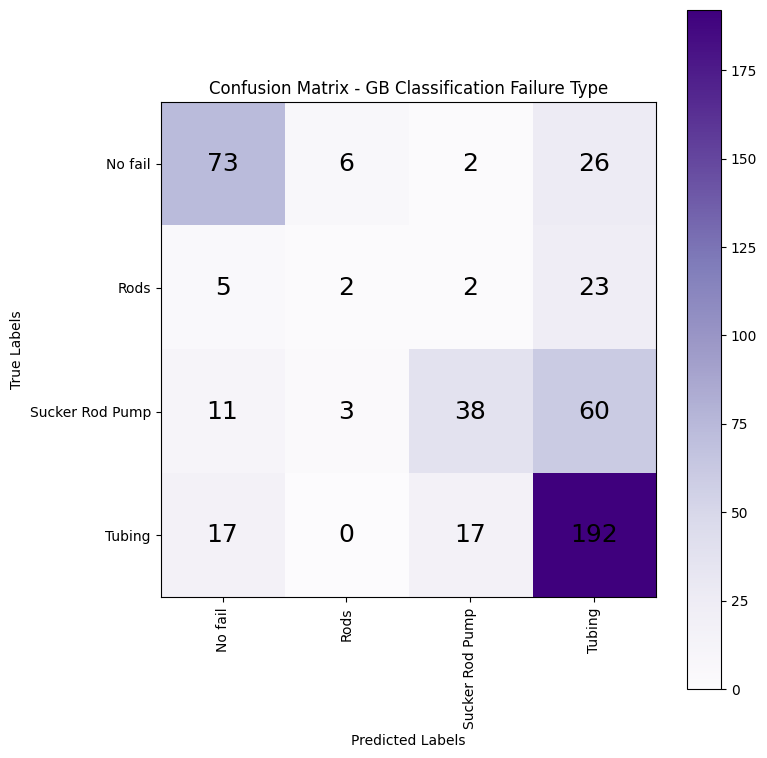

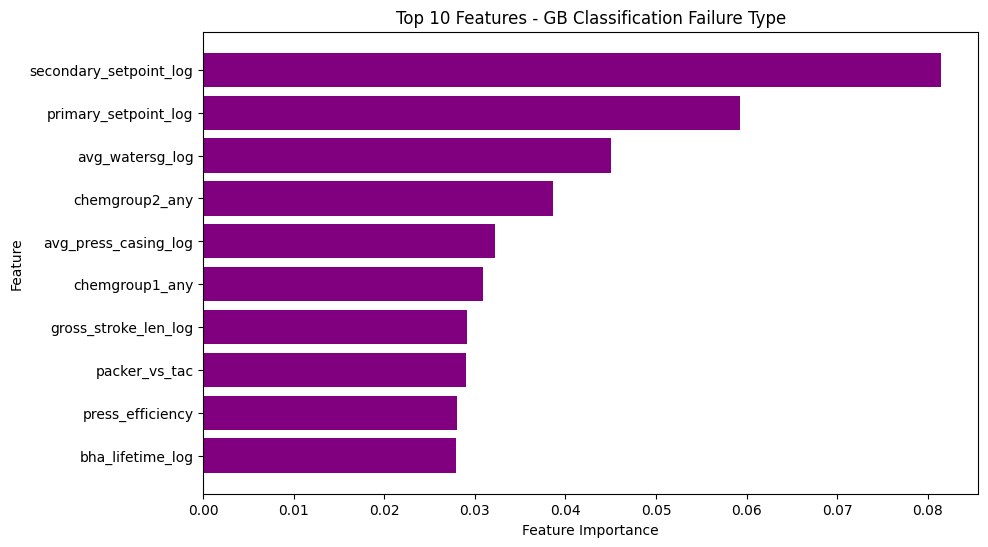

In [553]:
# Decode categorical labels back to original form
y_test_original = label_encoders['failure_type'].inverse_transform(y_test)
y_test_pred_original = label_encoders['failure_type'].inverse_transform(y_test_pred)

# Generate confusion matrix with original labels
conf_matrix = confusion_matrix(y_test_original, y_test_pred_original)

# Plot Confusion Matrix with readable labels
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, cmap='Purples', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=np.arange(len(label_encoders['failure_type'].classes_)), labels=label_encoders['failure_type'].classes_, rotation=90)
plt.yticks(ticks=np.arange(len(label_encoders['failure_type'].classes_)), labels=label_encoders['failure_type'].classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - GB Classification Failure Type")

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]),
                 ha='center', va='center', fontsize=18, color='black')
plt.tight_layout()
plt.show()

# Feature importance
feature_importances = best_xgb.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color = 'purple')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features - GB Classification Failure Type")
plt.gca().invert_yaxis()
plt.show()